In [7]:
library(tidyverse)
library(glmnet)
library(doParallel)
library(ggpubr)
library(scales)
library(pROC)

In [3]:
#Open the data files
input_odor_desc_wide <- read.delim("./ohe_features/optimized_desc_svc_ohe.csv", sep=',', header=T, row.names = 1)
input_odor_resp_wide <- read.delim("./compiled_desc_resp/compiled_odor_sigResp_wide.csv", sep=',', header=T, row.names = 1)
#Create a matrix of all possible pairwise combinations of the different odors
odor_perms  <- t(combn(row.names(input_odor_desc_wide), 2))

In [12]:

#Feature Euclidean distance
calc_vec_dist <- function(input_vector){
    vect_dist <- as.matrix(dist(input_vector))
    vect_dist[lower.tri(vect_dist, diag=T)] <- NA
    vect_dist <- na.omit(reshape2::melt(vect_dist))
    return(vect_dist$value)
}

#Response Euclidean distance
calc_resp_distance <- function(A) {
    square_dist <- as.matrix(dist(A))
    square_dist[lower.tri(square_dist, diag=T)] <- NA
    square_dist <- na.omit(reshape2::melt(square_dist))
    return(square_dist$value)
}

#Response correlation distance
calc_resp_corr_dist <- function(A){
    square_corr_dist <- as.matrix(1-cor(t(A)))
    square_corr_dist[lower.tri(square_corr_dist, diag=T)] <- NA
    square_corr_dist <- na.omit(reshape2::melt(square_corr_dist))
    return(square_corr_dist$value)
}

#Response cosine distance
calc_resp_cos_dist <- function(A){
    Matrix <- as.matrix(A)
    sim <- Matrix / sqrt(rowSums(Matrix * Matrix))
    sim <- sim %*% t(sim)
    sim <- 1-sim
    sim[lower.tri(sim, diag=T)] <- NA
    sim <- na.omit(reshape2::melt(sim))
    return(sim$value)
}

#Create function to resample with replacement
resample_with_replacement <- function(input_vector){
    resampled_vector <- input_vector[sample(length(input_vector), replace=TRUE)]
    return(resampled_vector)
}

#Function to scale resampled data
scale_resample <- function(input_vector){
    if (var(input_vector) == 0){
        input_vector <- rep(0, length(input_vector))
    } else {
        input_vector <- scale(input_vector, center=TRUE, scale=TRUE)
    }
    return(input_vector)
}

set.seed(42)

#Generate fictitious odors whose features are drawn from
#the distribution of features from the tested odors
shuffled_odor_desc_wide <- apply(input_odor_desc_wide, 2, resample_with_replacement)
row.names(shuffled_odor_desc_wide) <- row.names(input_odor_desc_wide)
#write.csv(shuffled_odor_desc_wide, "./ohe_features/shuffle_optimized_desc_svc_ohe.csv")



# Feature optimization plots

In [11]:
#Load SVC probabilities of prediction
svc_probabilities_long <- read.delim("./ohe_features/ohe_svc_preds_long.csv", header=T, sep=',', row.names = 1)
svc_probabilities_ls <- split(svc_probabilities_long, svc_probabilities_long$feature)

In [12]:
#Function to calculate FPR/TPR
calculate_fpr_tpr <- function(df){
    roc_model <- roc(df$true, df$prediction, levels = c(0,1), direction = "<")
    fpr <- 1 - roc_model$sensitivities
    tpr <- roc_model$specificities
    auroc <- roc_model$auc
    roc_out <- cbind.data.frame(tpr = tpr, fpr = fpr, feature = unique(df$feature), auroc = rep(auroc))
    return(roc_out)
}
#Calculate fpr/tpr
svc_fpr_tpr <- lapply(svc_probabilities_ls, calculate_fpr_tpr)
svc_fpr_tpr <- do.call("rbind", svc_fpr_tpr)
row.names(svc_fpr_tpr) <- NULL
svc_fpr_tpr$significance <- ifelse(svc_fpr_tpr$auroc > 0.5, "1", "0")
svc_fpr_tpr$significance <- factor(svc_fpr_tpr$significance, levels = c("0","1"))
#Compile all into a single df
decoded_feats <- subset(svc_probabilities_long, feature %in% subset(svc_fpr_tpr, significance == "1")$feature)
decoded_roc <- roc(decoded_feats$true, decoded_feats$prediction, levels = c(0,1), direction = "<")
decoded_info <- cbind.data.frame(fpr = 1 - decoded_roc$sensitivities, tpr = decoded_roc$specificities)


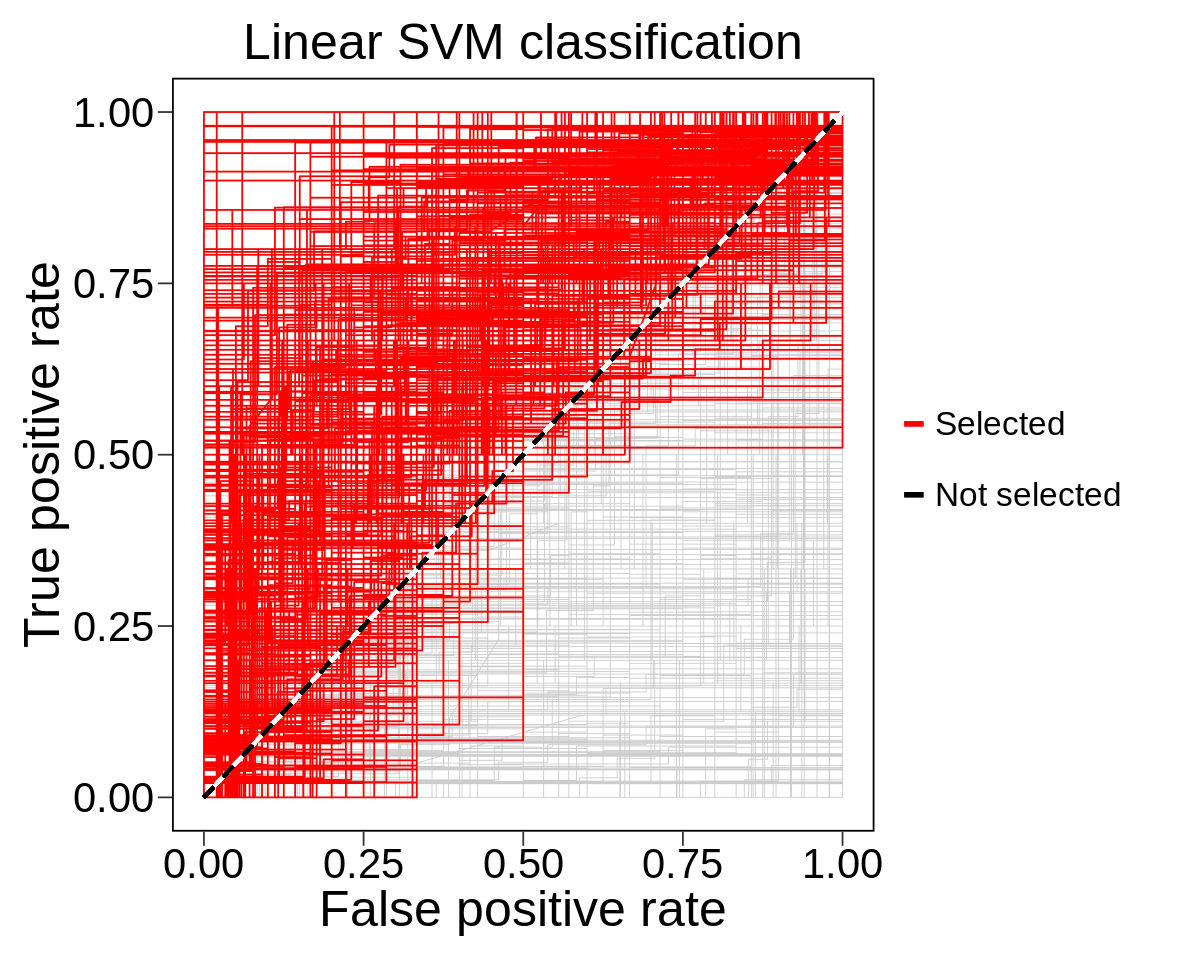

In [13]:
classifier_feature_selection <- ggplot(svc_fpr_tpr, aes(x = fpr, y = tpr, color = significance)) +
    geom_path(alpha = 0.2, size = 0.25) +
    geom_path(data = subset(svc_fpr_tpr, significance == 1),
              aes(x = fpr, y = tpr, color = significance), alpha = 1, size = 0.5) +
    xlab("False positive rate") +
    ylab("True positive rate") +
    ggtitle("Linear SVM classification") +
    scale_color_manual(labels = c("1" = "Selected","0" = "Not selected"),
                       values = c("1" = "red", "0" = "black")) +
    #geom_path(data = decoded_info, aes(x = fpr, y = tpr), color = "red", alpha = 1, size = 2) +
    geom_segment(aes(x = 0, xend = 1, y = 0, yend = 1),
                 color = "white", linetype = "solid", size = 1) +
    geom_segment(aes(x = 0, xend = 1, y = 0, yend = 1),
                 color = "black", linetype = "dashed", size = 1) +
    theme(legend.key=element_blank(),
          legend.title = element_blank(),
          legend.direction = "vertical",
          legend.text = element_text(size = 20),
          legend.key.size = unit(1.5, 'cm'),
          plot.background = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5),
          panel.border = element_rect(fill=NA, color="black", size = 1),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line.x = element_blank(),
          axis.line.y = element_blank(),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_text(color = "black", size = 30),
          axis.title.y = element_text(color = "black", size = 30),
          axis.ticks.length.x = unit(.3, "cm"),
          axis.ticks.length.y = unit(.3, "cm"),
          plot.margin = margin(t=0.5,r=1.5,b=0.5,l=0.5, "cm")) +
    #annotate("text", size = 8, x = 0.75, y = 0.1, color = "red",
    #         label = paste("AUC:",round(decoded_roc$auc, digits = 4))) +
    guides(color = guide_legend(override.aes = list(size = 1.5, alpha = 1), keywidth = 1))


options(repr.plot.width=10, repr.plot.height=8)
classifier_feature_selection
#ggsave("./plots/fig_3_supp3a_1.pdf", classifier_feature_selection, height = 8, width = 10, limitsize = FALSE)

In [15]:
#Load distances data
optimized_desc_distances <- read.delim("./ohe_features/ohe_optimized_descriptors_distances.csv",
                                       header=T, sep=',',row.names = 1)

`geom_smooth()` using formula 'y ~ x'



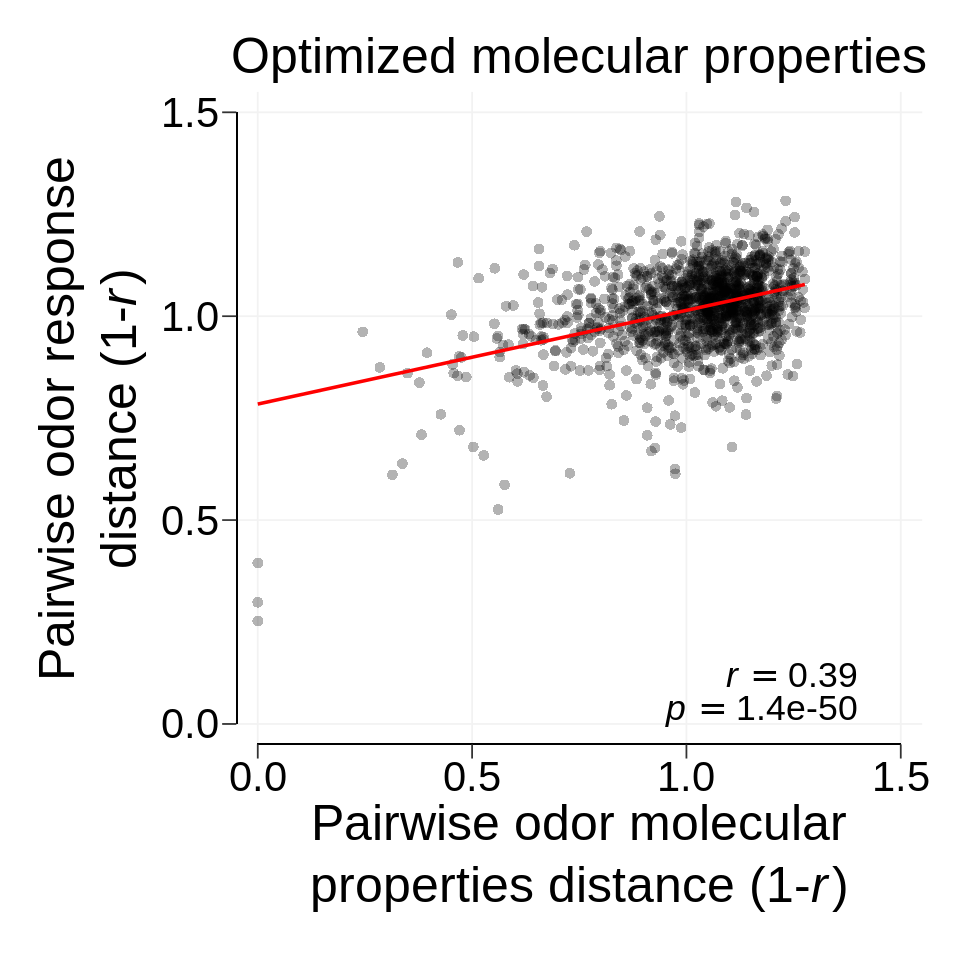

In [21]:
Rcor_Pcor_r <- cor(optimized_desc_distances$response_corr_distance, optimized_desc_distances$feature_corr_distance)
Rcor_Pcor_r_p <- cor.test(optimized_desc_distances$response_corr_distance, optimized_desc_distances$feature_corr_distance)

predictive_descriptors_plot <- ggplot(data = optimized_desc_distances, aes(x = feature_corr_distance, y = response_corr_distance)) +
    ggtitle("Optimized molecular properties") +
    geom_point(size = 3, alpha = 0.3, stroke = 0) +
    xlab(bquote(atop("Pairwise odor molecular",
                     paste("properties distance (1-",italic(r),")")))) +
    ylab(bquote(atop("Pairwise odor response",
                     paste("distance (1-",italic(r),")")))) +
    scale_x_continuous(breaks = seq(0,1.5,.5), limits = c(-0.05,1.55), expand = c(0,0)) +
    scale_y_continuous(breaks = seq(0,1.5,.5), limits = c(-0.05,1.55), expand = c(0,0)) +
    geom_segment(aes(x = 0, xend = 1.5, y = -0.05, yend = -0.05)) +
    geom_segment(aes(x = -0.05, xend = -0.05, y = 0, yend = 1.5)) +
    theme(plot.background = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line.x = element_blank(),
          axis.line.y = element_blank(),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_text(color = "black", size = 30),
          axis.title.y = element_text(color = "black", size = 30),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.8,r=0.8,b=0.8,l=0.8, "cm")) +
    geom_smooth(method=lm, color = "red", se=F) +
    annotate("text", x = 1.4, y = 0.12, label = paste("italic(r) ==", round(Rcor_Pcor_r, 2)), parse=T, size = 7.5, hjust = 1) +
    annotate("text", x = 1.4, y = 0.03, label = paste("italic(p) ==", signif(Rcor_Pcor_r_p$p.value, digits = 2)), parse=T, size = 7.5, hjust = 1)


options(repr.plot.width=8, repr.plot.height=8)
predictive_descriptors_plot
#ggsave("./plots/fig_3c.pdf", predictive_descriptors_plot, height = 8, width = 8)

In [30]:
min(optimized_desc_distances$feature_euc_distance)
max(optimized_desc_distances$feature_euc_distance)
min(optimized_desc_distances$response_euc_distance)
max(optimized_desc_distances$response_euc_distance)

[1] 0

[1] 36.7582

[1] 14.24607

[1] 50.56901

In [41]:
#Calculate r values
Reuc_Peuc_r <- cor(optimized_desc_distances$response_euc_distance, optimized_desc_distances$feature_euc_distance)
Reuc_Pcor_r <- cor(optimized_desc_distances$response_euc_distance, optimized_desc_distances$feature_corr_distance)
Reuc_Pcos_r <- cor(optimized_desc_distances$response_euc_distance, optimized_desc_distances$feature_cos_distance)
Rcor_Peuc_r <- cor(optimized_desc_distances$response_corr_distance, optimized_desc_distances$feature_euc_distance)
Rcor_Pcor_r <- cor(optimized_desc_distances$response_corr_distance, optimized_desc_distances$feature_corr_distance)
Rcor_Pcos_r <- cor(optimized_desc_distances$response_corr_distance, optimized_desc_distances$feature_cos_distance)
Rcos_Peuc_r <- cor(optimized_desc_distances$response_cos_distance, optimized_desc_distances$feature_euc_distance)
Rcos_Pcor_r <- cor(optimized_desc_distances$response_cos_distance, optimized_desc_distances$feature_corr_distance)
Rcos_Pcos_r <- cor(optimized_desc_distances$response_cos_distance, optimized_desc_distances$feature_cos_distance)

#Calculate p-values
Reuc_Peuc_r_p <- cor.test(optimized_desc_distances$response_euc_distance, optimized_desc_distances$feature_euc_distance)
Reuc_Pcor_r_p <- cor.test(optimized_desc_distances$response_euc_distance, optimized_desc_distances$feature_corr_distance)
Reuc_Pcos_r_p <- cor.test(optimized_desc_distances$response_euc_distance, optimized_desc_distances$feature_cos_distance)
Rcor_Peuc_r_p <- cor.test(optimized_desc_distances$response_corr_distance, optimized_desc_distances$feature_euc_distance)
Rcor_Pcor_r_p <- cor.test(optimized_desc_distances$response_corr_distance, optimized_desc_distances$feature_corr_distance)
Rcor_Pcos_r_p <- cor.test(optimized_desc_distances$response_corr_distance, optimized_desc_distances$feature_cos_distance)
Rcos_Peuc_r_p <- cor.test(optimized_desc_distances$response_cos_distance, optimized_desc_distances$feature_euc_distance)
Rcos_Pcor_r_p <- cor.test(optimized_desc_distances$response_cos_distance, optimized_desc_distances$feature_corr_distance)
Rcos_Pcos_r_p <- cor.test(optimized_desc_distances$response_cos_distance, optimized_desc_distances$feature_cos_distance)


#Make plots
eucD_eucN_plot <- ggplot(data = optimized_desc_distances, aes(x = feature_euc_distance, y = response_euc_distance)) +
    geom_point(size = 3, alpha = 0.3, stroke = 0) +
    ggtitle("Response: Euclidean\nProperty: Euclidean") +
    scale_x_continuous(breaks = seq(0,40,10), limits = c(-2,42), expand = c(0,0)) +
    scale_y_continuous(breaks = seq(10,60,10), limits = c(7,63), expand = c(0,0)) +
    geom_segment(aes(x = 0, xend = 40, y = 7, yend = 7)) +
    geom_segment(aes(x = -2, xend = -2, y = 10, yend = 60)) +
    theme(plot.background = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5),
          axis.line.x = element_blank(),
          axis.line.y = element_blank(),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.8,r=0.8,b=0.8,l=0.8, "cm")) +
    geom_smooth(method=lm, color = "red", se=F) +
    annotate("text", x = 40, y = 60, label = paste("italic(r) ==",round(Reuc_Peuc_r,2)), parse=T, size = 7.5, hjust = 1) +
    annotate("text", x = 40, y = 55, label = paste("italic(p) ==", signif(Reuc_Peuc_r_p$p.value, digits = 2)), parse=T, size = 7.5, hjust = 1)

eucD_corN_plot <- ggplot(data = optimized_desc_distances, aes(x = feature_euc_distance, y = response_corr_distance)) +
    geom_point(size = 3, alpha = 0.3, stroke = 0) +
    ggtitle("Response: correlation\nProperty: Euclidean") +
    scale_x_continuous(breaks = seq(0,40,10), limits = c(-2,42), expand = c(0,0)) +
    scale_y_continuous(breaks = seq(0,2,0.5), limits = c(-0.1,2.1), expand = c(0,0)) +
    geom_segment(aes(x = 0, xend = 40, y = -0.1, yend = -0.1)) +
    geom_segment(aes(x = -2, xend = -2, y = 0, yend = 2)) +
    theme(plot.background = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5),
          axis.line.x = element_blank(),
          axis.line.y = element_blank(),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.8,r=0.8,b=0.8,l=0.8, "cm")) +
    geom_smooth(method=lm, color = "red", se=F) +
    annotate("text", x = 40, y = 2, label = paste("italic(r) ==",round(Reuc_Pcor_r,2)), parse=T, size = 7.5, hjust = 1) +
    annotate("text", x = 40, y = 1.8, label = paste("italic(p) ==", signif(Reuc_Pcor_r_p$p.value, digits = 2)), parse=T, size = 7.5, hjust = 1)

eucD_cosN_plot <- ggplot(data = optimized_desc_distances, aes(x = feature_euc_distance, y = response_cos_distance)) +
    geom_point(size = 3, alpha = 0.3, stroke = 0) +
    ggtitle("Response: cosine\nProperty: Euclidean") +
    scale_x_continuous(breaks = seq(0,40,10), limits = c(-2,42), expand = c(0,0)) +
    scale_y_continuous(breaks = seq(0,2,0.5), limits = c(-0.1,2.1), expand = c(0,0)) +
    geom_segment(aes(x = 0, xend = 40, y = -0.1, yend = -0.1)) +
    geom_segment(aes(x = -2, xend = -2, y = 0, yend = 2)) +
    theme(plot.background = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5),
          axis.line.x = element_blank(),
          axis.line.y = element_blank(),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.8,r=0.8,b=0.8,l=0.8, "cm")) +
    geom_smooth(method=lm, color = "red", se=F) +
    annotate("text", x = 40, y = 2, label = paste("italic(r) ==",round(Reuc_Pcos_r,2)), parse=T, size = 7.5, hjust = 1) +
    annotate("text", x = 40, y = 1.8, label = paste("italic(p) ==", signif(Reuc_Pcos_r_p$p.value, digits = 2)), parse=T, size = 7.5, hjust = 1)

corD_eucN_plot <- ggplot(data = optimized_desc_distances, aes(x = feature_corr_distance, y = response_euc_distance)) +
    geom_point(size = 3, alpha = 0.3, stroke = 0) +
    ggtitle("Response: Euclidean\nProperty: correlation") +
    scale_x_continuous(breaks = seq(0,2,0.5), limits = c(-0.1,2.1), expand = c(0,0)) +
    scale_y_continuous(breaks = seq(10,60,10), limits = c(7,63), expand = c(0,0)) +
    geom_segment(aes(x = -0.1, xend = -0.1, y = 10, yend = 60)) +
    geom_segment(aes(x = 0, xend = 2, y = 7, yend = 7)) +
    theme(plot.background = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line.x = element_blank(),
          axis.line.y = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.8,r=0.8,b=0.8,l=0.8, "cm")) +
    geom_smooth(method=lm, color = "red", se=F) +
    annotate("text", x = 2, y = 60, label = paste("italic(r) ==",round(Rcor_Peuc_r,2)), parse=T, size = 7.5, hjust = 1) +
    annotate("text", x = 2, y = 55, label = paste("italic(p) ==", signif(Rcor_Peuc_r_p$p.value, digits = 2)), parse=T, size = 7.5, hjust = 1)

corD_corN_plot <- ggplot(data = optimized_desc_distances, aes(x = feature_corr_distance, y = response_corr_distance)) +
    geom_point(size = 3, alpha = 0.3, stroke = 0) +
    ggtitle("Response: correlation\nProperty: correlation") +
    scale_x_continuous(breaks = seq(0,2,0.5), limits = c(-0.1,2.1), expand = c(0,0)) +
    scale_y_continuous(breaks = seq(0,2,0.5), limits = c(-0.1,2.1), expand = c(0,0)) +
    geom_segment(aes(x = 0, xend = 2, y = -0.1, yend = -0.1)) +
    geom_segment(aes(x = -0.1, xend = -0.1, y = 0, yend = 2)) +
    theme(plot.background = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line.x = element_blank(),
          axis.line.y = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.8,r=0.8,b=0.8,l=0.8, "cm")) +
    geom_smooth(method=lm, color = "red", se=F) +
    annotate("text", x = 2, y = 2, label = paste("italic(r) ==",round(Rcor_Pcor_r,2)), parse=T, size = 7.5, hjust = 1) +
    annotate("text", x = 2, y = 1.8, label = paste("italic(p) ==", signif(Rcor_Pcor_r_p$p.value, digits = 2)), parse=T, size = 7.5, hjust = 1)

corD_cosN_plot <- ggplot(data = optimized_desc_distances, aes(x = feature_corr_distance, y = response_cos_distance)) +
    geom_point(size = 3, alpha = 0.3, stroke = 0) +
    ggtitle("Response: cosine\nProperty: correlation") +
    #xlab("Pairwise odor molecular\nproperties distance") +
    #ylab("Pairwise odor response\ndistance") +
    scale_x_continuous(breaks = seq(0,2,0.5), limits = c(-0.1,2.1), expand = c(0,0)) +
    scale_y_continuous(breaks = seq(0,2,0.5), limits = c(-0.1,2.1), expand = c(0,0)) +
    geom_segment(aes(x = 0, xend = 2, y = -0.1, yend = -0.1)) +
    geom_segment(aes(x = -0.1, xend = -0.1, y = 0, yend = 2)) +
    theme(plot.background = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line.x = element_blank(),
          axis.line.y = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.8,r=0.8,b=0.8,l=0.8, "cm")) +
    geom_smooth(method=lm, color = "red", se=F) +
    annotate("text", x = 2, y = 2, label = paste("italic(r) ==",round(Rcor_Pcos_r,2)), parse=T, size = 7.5, hjust =1) +
    annotate("text", x = 2, y = 1.8, label = paste("italic(p) ==", signif(Rcor_Pcos_r_p$p.value, digits = 2)), parse=T, size = 7.5, hjust = 1)

cosD_eucN_plot <- ggplot(data = optimized_desc_distances, aes(x = feature_cos_distance, y = response_euc_distance)) +
    geom_point(size = 3, alpha = 0.3, stroke = 0) +
    ggtitle("Response: Euclidean\nProperty: cosine") +
    scale_x_continuous(breaks = seq(0,2,0.5), limits = c(-0.1,2.1), expand = c(0,0)) +
    scale_y_continuous(breaks = seq(10,60,10), limits = c(7,63), expand = c(0,0)) +
    geom_segment(aes(x = 0, xend = 2, y = 7, yend = 7)) +
    geom_segment(aes(x = -0.1, xend = -0.1, y = 10, yend = 60)) +
    theme(plot.background = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line.x = element_blank(),
          axis.line.y = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.8,r=0.8,b=0.8,l=0.8, "cm")) +
    geom_smooth(method=lm, color = "red", se=F) +
    annotate("text", x = 2, y = 60, label = paste("italic(r) ==",round(Rcos_Peuc_r,2)), parse=T, size = 7.5, hjust = 1) +
    annotate("text", x = 2, y = 55, label = paste("italic(p) ==", signif(Rcos_Peuc_r_p$p.value, digits = 2)), parse=T, size = 7.5, hjust = 1)

cosD_corN_plot <- ggplot(data = optimized_desc_distances, aes(x = feature_cos_distance, y = response_corr_distance)) +
    geom_point(size = 3, alpha = 0.3, stroke = 0) +
    ggtitle("Response: correlation\nProperty: cosine") +
    scale_x_continuous(breaks = seq(0,2,0.5), limits = c(-0.1,2.1), expand = c(0,0)) +
    scale_y_continuous(breaks = seq(0,2,0.5), limits = c(-0.1,2.1), expand = c(0,0)) +
    geom_segment(aes(x = 0, xend = 2, y = -0.1, yend = -0.1)) +
    geom_segment(aes(x = -0.1, xend = -0.1, y = 0, yend = 2)) +
    theme(plot.background = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line.x = element_blank(),
          axis.line.y = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.8,r=0.8,b=0.8,l=0.8, "cm")) +
    geom_smooth(method=lm, color = "red", se=F) +
    annotate("text", x = 2, y = 2, label = paste("italic(r) ==",round(Rcos_Pcor_r,2)), parse=T, size = 7.5, hjust = 1) +
    annotate("text", x = 2, y = 1.8, label = paste("italic(p) ==", signif(Rcos_Pcor_r_p$p.value, digits = 2)), parse=T, size = 7.5, hjust = 1)

cosD_cosN_plot <- ggplot(data = optimized_desc_distances, aes(x = feature_cos_distance, y = response_cos_distance)) +
    geom_point(size = 3, alpha = 0.3, stroke = 0) +
    ggtitle("Response: cosine\nProperty: cosine") +
    scale_x_continuous(breaks = seq(0,2,0.5), limits = c(-0.1,2.1), expand = c(0,0)) +
    scale_y_continuous(breaks = seq(0,2,0.5), limits = c(-0.1,2.1), expand = c(0,0)) +
    geom_segment(aes(x = 0, xend = 2, y = -0.1, yend = -0.1)) +
    geom_segment(aes(x = -0.1, xend = -0.1, y = 0, yend = 2)) +
    theme(plot.background = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line.x = element_blank(),
          axis.line.y = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.8,r=0.8,b=0.8,l=0.8, "cm")) +
    geom_smooth(method=lm, color = "red", se=F) +
    annotate("text", x = 2, y = 2, label = paste("italic(r) ==",round(Rcos_Pcos_r,2)), parse=T, size = 7.5, hjust = 1) +
    annotate("text", x = 2, y = 1.8, label = paste("italic(p) ==", signif(Rcos_Pcos_r_p$p.value, digits = 2)), parse=T, size = 7.5, hjust = 1)



`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



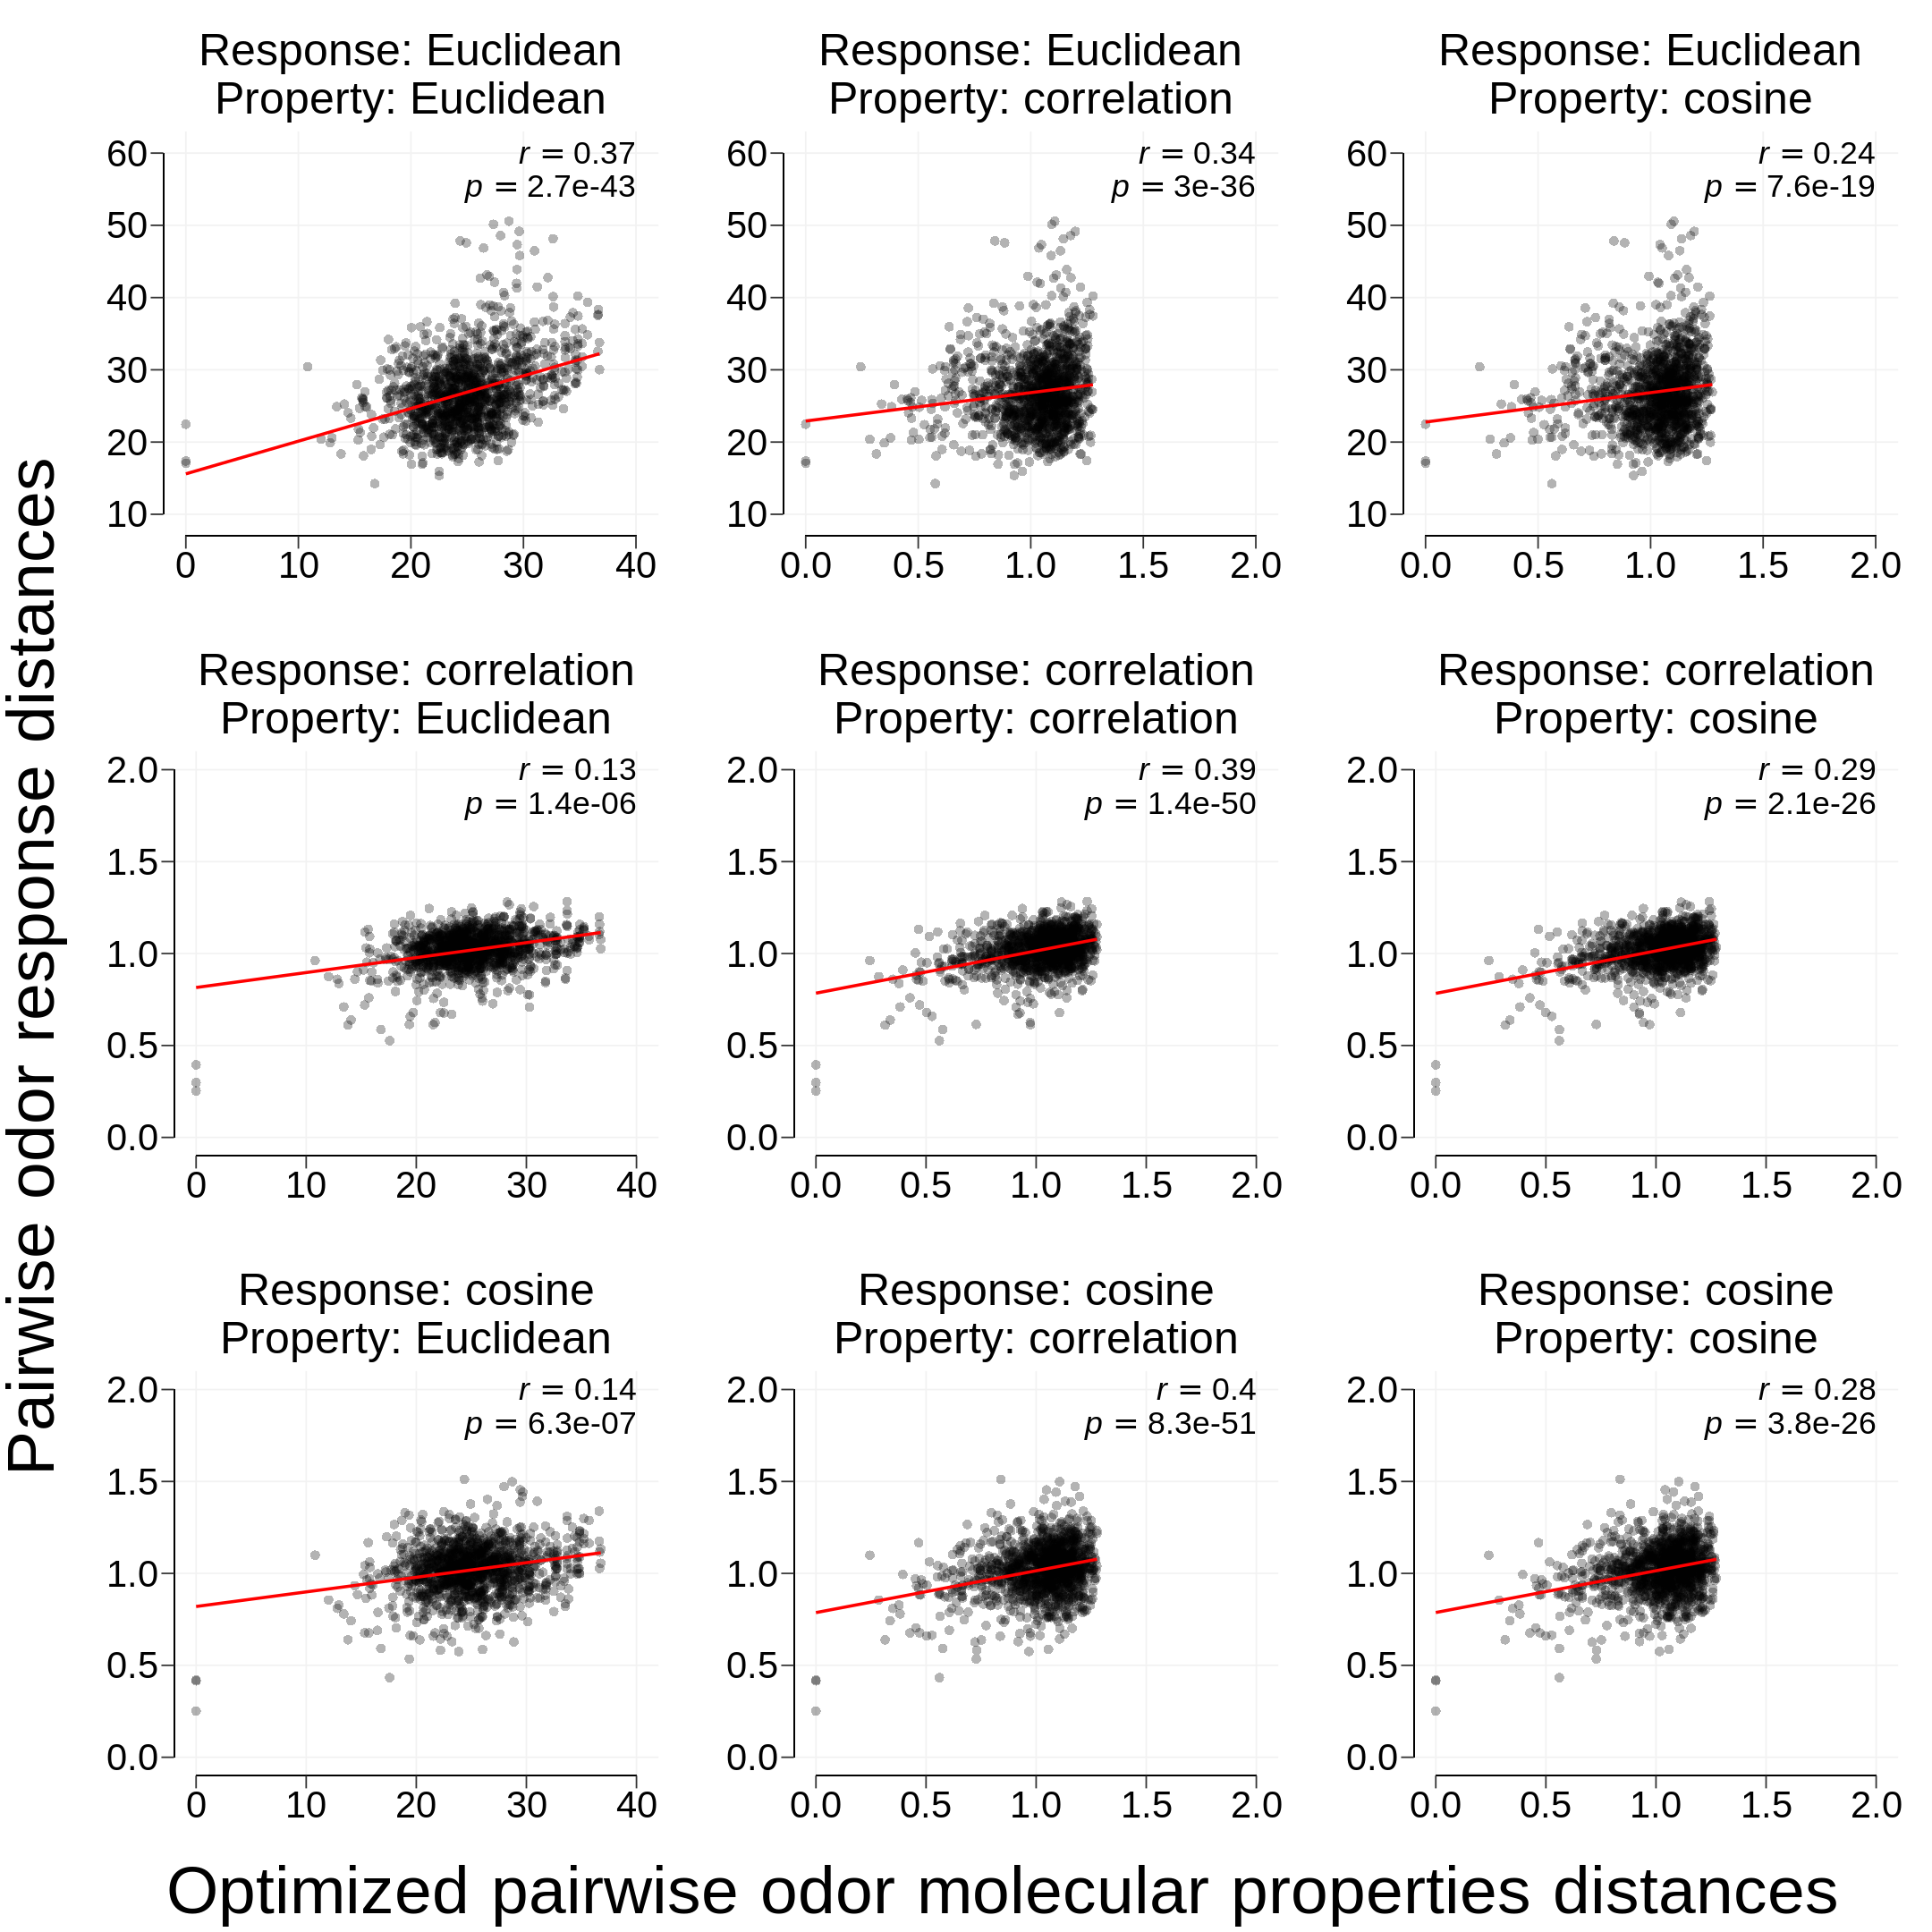

In [42]:
optim_response_desc_combined <- ggarrange(eucD_eucN_plot, corD_eucN_plot, cosD_eucN_plot,
                                    eucD_corN_plot, corD_corN_plot, cosD_corN_plot,
                                    eucD_cosN_plot, corD_cosN_plot, cosD_cosN_plot,
                                    ncol = 3, nrow = 3)
optim_response_desc_combined <- annotate_figure(optim_response_desc_combined,
                                          left = text_grob(bquote(Pairwise~odor~response~distances), rot = 90, size = 45),
                                          bottom = text_grob(bquote(Optimized~pairwise~odor~molecular~properties~distances), size = 45)
                                         )

options(repr.plot.width=18, repr.plot.height=18)
options(scipen=-1)
optim_response_desc_combined
#ggsave("./plots/fig_3_supp3b.pdf",optim_response_desc_combined, height = 18, width = 18)

# Ridge regression - all data

In [1]:
#set.seed(42)
#
##Can run locally
#lambda_array <- seq(from = 0, to = 3, length = 1000)
#lasso_eval <- list()
#linear_models <- list()
#
##Normalize the data
#norm_input_odor_desc_wide <- scale(input_odor_desc_wide, center=TRUE, scale=TRUE)
#norm_input_odor_resp_wide <- scale(input_odor_resp_wide, center=TRUE, scale=TRUE)
#
##Training dataset distance calculation
#xtrain <- apply(norm_input_odor_desc_wide, 2, calc_vec_dist)
#ytrain_Euc <- calc_resp_distance(norm_input_odor_resp_wide)
#ytrain_cor <- calc_resp_corr_dist(norm_input_odor_resp_wide)
#ytrain_cos <- calc_resp_cos_dist(norm_input_odor_resp_wide)
#
##Train the linear models
#linear_model_Euc <- glmnet(xtrain, ytrain_Euc,
#                           parallel = TRUE,
#                           type.measure="mse",
#                           alpha=0,
#                           lambda = lambda_array,
#                           family="gaussian")
#linear_model_cor <- glmnet(xtrain, ytrain_cor,
#                           parallel = TRUE,
#                           type.measure="mse",
#                           alpha=0,
#                           lambda = lambda_array,
#                           family="gaussian")
#linear_model_cos <- glmnet(xtrain, ytrain_cos,
#                           parallel = TRUE,
#                           type.measure="mse",
#                           alpha=0,
#                           lambda = lambda_array,
#                           family="gaussian")
#
#
##Make predictions
#ypred_Euc <- predict(linear_model_Euc, s = lambda_array, newx=xtrain, type = "response")
#ypred_cor <- predict(linear_model_cor, s = lambda_array, newx=xtrain, type = "response")
#ypred_cos <- predict(linear_model_cos, s = lambda_array, newx=xtrain, type = "response")
#
##Evaluate model fitting
#full_pcorr_Euc <- apply(ypred_Euc, 2, function(x) cor(x,ytrain_Euc))
#full_mse_Euc <- colMeans(apply(ypred_Euc, 2, function(x) ((x-ytrain_Euc)^2)))                        
#full_pcorr_cor <- apply(ypred_cor, 2, function(x) cor(x,ytrain_cor))
#full_mse_cor <- colMeans(apply(ypred_cor, 2, function(x) ((x-ytrain_cor)^2)))
#full_pcorr_cos <- apply(ypred_cos, 2, function(x) cor(x,ytrain_cos))
#full_mse_cos <- colMeans(apply(ypred_cos, 2, function(x) ((x-ytrain_cos)^2)))
#
#                               
##Compile model fitting results
#rr_full_data <- data.frame(cbind(full_pcorr_Euc = full_pcorr_Euc,
#                                    full_mse_Euc = full_mse_Euc,
#                                    full_pcorr_cor = full_pcorr_cor,
#                                    full_mse_cor = full_mse_cor,
#                                    full_pcorr_cos = full_pcorr_cos,
#                                    full_mse_cos = full_mse_cos,
#                                    lambda = rev(linear_model_Euc$lambda),
#                                    nFeats_Euc = rev(linear_model_Euc$df),
#                                    nFeats_cor = rev(linear_model_cor$df),
#                                    nFeats_cos = rev(linear_model_cos$df)))
#                               
#write.csv(rr_full_data, "./ohe_features/rr_full_data_optDesc_variousMetrics.csv")

# Ridge regression - LOOCV

In [ ]:
##Initialize lists and DFs
#regression_model_Euc <- list()
#regression_model_cor <- list()
#regression_model_cos <- list()
#lambdaArray_out <- list()
#zero_var_feats <- data.frame()
#
##Set lambda array
#lambda_array <- seq(from = 0, to = 3, length = 1000)
#
#
#for (i in seq(1:nrow(odor_perms))){
#    print(i)
#    #Select test odors
#    odor1 <- odor_perms[i,1]
#    odor2 <- odor_perms[i,2]
#    odor_list <- c(odor1, odor2)
#    odor_set <- paste0("CID","_",odor1,"_",odor2)
#    #Select test rows
#    test_odors_rows <- which(row.names(input_odor_desc_wide) %in% odor_list)
#    #Setup the descriptors data
#    train_odors_desc <- input_odor_desc_wide[-test_odors_rows,]
#    test_odors_desc <- input_odor_desc_wide[test_odors_rows,]
#    shuffled_test_odors_desc <- shuffled_odor_desc_wide[test_odors_rows,]
#    #Setup the response data
#    train_odors_resp <- input_odor_resp_wide[-test_odors_rows,]
#    test_odors_resp <- input_odor_resp_wide[test_odors_rows,]
#    #Find features with zero variance 
#    zero_var_cols <- which(apply(train_odors_desc, 2, var) == 0)
#    if (length(zero_var_cols) > 0) {
#        tempZero <- data.frame(i, odor1, odor2, zero_var_cols, names(zero_var_cols))
#        zero_var_feats <- rbind(zero_var_feats, tempZero)
#        #Remove features with zero variance
#        zero_var_cols <- as.numeric(zero_var_cols)
#        train_odors_desc <- train_odors_desc[,-zero_var_cols]
#        test_odors_desc <- test_odors_desc[,-zero_var_cols]
#        shuffled_test_odors_desc <- shuffled_test_odors_desc[,-zero_var_cols]
#    }
#    #Center/scale the train data
#    norm_train_odors_desc <- scale(train_odors_desc, center=TRUE, scale=TRUE)
#    norm_train_odors_resp <- scale(train_odors_resp, center=TRUE, scale=TRUE)
#    #Center/scale the test data
#    norm_test_odors_desc <- scale(test_odors_desc, center=attr(norm_train_odors_desc, "scaled:center"),
#                                                   scale=attr(norm_train_odors_desc, "scaled:scale"))
#    norm_shuffled_test_odors_desc <- scale(shuffled_test_odors_desc, center=attr(norm_train_odors_desc, "scaled:center"),
#                                                                     scale=attr(norm_train_odors_desc, "scaled:scale"))
#    norm_test_odors_resp <- scale(test_odors_resp, center=attr(norm_train_odors_resp, "scaled:center"),
#                                                   scale=attr(norm_train_odors_resp, "scaled:scale"))
#    #Calculate distances between individual features in descriptor space
#    xtrain_dist <- apply(norm_train_odors_desc, 2, calc_vec_dist)
#    xtest_dist <- apply(norm_test_odors_desc, 2, calc_vec_dist)
#    xshuffle_dist <- apply(norm_shuffled_test_odors_desc, 2, calc_vec_dist)
#    #Calculate distances in response space
#    ytrain_Euc <- as.matrix(calc_resp_distance(norm_train_odors_resp))
#    ytrain_cor <- as.matrix(calc_resp_corr_dist(norm_train_odors_resp))
#    ytrain_cos <- as.matrix(calc_resp_cos_dist(norm_train_odors_resp))
#    ytest_Euc <- as.matrix(calc_resp_distance(norm_test_odors_resp))
#    ytest_cor <- as.matrix(calc_resp_corr_dist(norm_test_odors_resp))
#    ytest_cos <- as.matrix(calc_resp_cos_dist(norm_test_odors_resp))
#    #Train linear models
#    linear_model_Euc <- glmnet(xtrain_dist, ytrain_Euc,
#                               parallel=TRUE,
#                               type.measure="mse", 
#                               alpha=0,
#                               lambda=lambda_array,
#                               family="gaussian")
#    linear_model_cor <- glmnet(xtrain_dist, ytrain_cor,
#                               parallel=TRUE,
#                               type.measure="mse", 
#                               alpha=0,
#                               lambda=lambda_array,
#                               family="gaussian")
#    linear_model_cos <- glmnet(xtrain_dist, ytrain_cos,
#                               parallel=TRUE,
#                               type.measure="mse", 
#                               alpha=0,
#                               lambda=lambda_array,
#                               family="gaussian")
#    regression_model_Euc[[odor_set]] <- linear_model_Euc
#    regression_model_cor[[odor_set]] <- linear_model_cor
#    regression_model_cos[[odor_set]] <- linear_model_cos
#    #Make predictions on intact test data
#    new_y <- data.frame()
#    ypred_Euc <- predict(linear_model_Euc, s = lambda_array, newx=xtest_dist, type = "response")
#    ypred_cor <- predict(linear_model_cor, s = lambda_array, newx=xtest_dist, type = "response")
#    ypred_cos <- predict(linear_model_cos, s = lambda_array, newx=xtest_dist, type = "response")
#    #Make predictions on shuffled test data
#    ypred_shuffled_Euc <- predict(linear_model_Euc, s = lambda_array, newx=xshuffle_dist, type = "response")
#    ypred_shuffled_cor <- predict(linear_model_cor, s = lambda_array, newx=xshuffle_dist, type = "response")
#    ypred_shuffled_cos <- predict(linear_model_cos, s = lambda_array, newx=xshuffle_dist, type = "response")
#    #Compile datasets
#    temp <- cbind.data.frame(ytest_Euc = rep(ytest_Euc), ytest_cor = rep(ytest_cor), ytest_cos = rep(ytest_cos),
#                             ypred_Euc = t(ypred_Euc), ypred_cor = t(ypred_cor), ypred_cos = t(ypred_cos),
#                             ypred_shuffled_Euc = t(ypred_shuffled_Euc), ypred_shuffled_cor = t(ypred_shuffled_cor), ypred_shuffled_cos = t(ypred_shuffled_cos),
#                             lambda = lambda_array,
#                             #coeff_Euc = rev(linear_model_Euc$df), coeff_cor = rev(linear_model_cor$df), coeff_cos = rev(linear_model_cos$df),
#                             odors = rep(odor_set))
#    temp$ypred_Euc_mse <- (temp$ytest_Euc - temp$ypred_Euc)^2
#    temp$ypred_cor_mse <- (temp$ytest_cor - temp$ypred_cor)^2
#    temp$ypred_cos_mse <- (temp$ytest_cos - temp$ypred_cos)^2
#    temp$ypred_shuffled_Euc_mse <- (temp$ytest_Euc - temp$ypred_shuffled_Euc)^2
#    temp$ypred_shuffled_cor_mse <- (temp$ytest_cor - temp$ypred_shuffled_cor)^2
#    temp$ypred_shuffled_cos_mse <- (temp$ytest_cos - temp$ypred_shuffled_cos)^2
#    lambdaArray_out[[odor_set]] <- temp
#}
#
#saveRDS(lambdaArray_out, "./ohe_features/rr_odorCV_preds_all_metrics.rds")
#saveRDS(regression_model_Euc, "./ohe_features/rr_odorCV_Euc_models.rds")
#saveRDS(regression_model_cor, "./ohe_features/rr_odorCV_cor_models.rds")
#saveRDS(regression_model_cos, "./ohe_features/rr_odorCV_cos_models.rds")

# Ridge regression - stats & plots

In [95]:
#Load full fit data
rr_full_data <- read.delim("./ohe_features/rr_full_data_optDesc_variousMetrics.csv", header=T, sep=',', row.names = 1)
rr_full_data <- subset(rr_full_data, lambda != 0)
#Load LOOCV data
rr_loocv <- readRDS("./ohe_features/rr_odorCV_preds_all_metrics.rds")
rr_loocv_compiled <- do.call("rbind", rr_loocv)
rr_loocv_compiled <- subset(rr_loocv_compiled, lambda != 0)
#Calculate LOOCV stats
rr_loocv_stats <- rr_loocv_compiled %>%
    group_by(lambda) %>%
    summarise(loocv_Euc_pcorr = cor(ytest_Euc, ypred_Euc),
              loocv_Euc_pcorr_shuffled = cor(ytest_Euc, ypred_shuffled_Euc),
              loocv_cor_pcorr = cor(ytest_cor, ypred_cor),
              loocv_cor_pcorr_shuffled = cor(ytest_cor, ypred_shuffled_cor),
              loocv_cos_pcorr = cor(ytest_cos, ypred_cos),
              loocv_cos_pcorr_shuffled = cor(ytest_cos, ypred_shuffled_cos),
              loocv_Euc_avg_mse = mean((ytest_Euc - ypred_Euc)^2),
              loocv_Euc_avg_mse_shuffled = mean((ytest_Euc - ypred_shuffled_Euc)^2),
              loocv_cor_avg_mse = mean((ytest_cor - ypred_cor)^2),
              loocv_cor_avg_mse_shuffled = mean((ytest_cor - ypred_shuffled_cor)^2),
              loocv_cos_avg_mse = mean((ytest_cos - ypred_cos)^2),
              loocv_cos_avg_mse_shuffled = mean((ytest_cos - ypred_shuffled_cos)^2))
#Compile LOOCV and full fit stats
rr_stats <- cbind.data.frame(rr_loocv_stats,
                             full_pcorr_Euc = rr_full_data$full_pcorr_Euc, full_mse_Euc = rr_full_data$full_mse_Euc,
                             full_pcorr_cor = rr_full_data$full_pcorr_cor, full_mse_cor = rr_full_data$full_mse_cor,
                             full_pcorr_cos = rr_full_data$full_pcorr_cos, full_mse_cos = rr_full_data$full_mse_cos)
row.names(rr_stats) <- NULL
rr_stats_gathered <- rr_stats %>%
    gather(key = "pcorr_Euc_id", value = "pcorr_Euc_value", full_pcorr_Euc, loocv_Euc_pcorr, loocv_Euc_pcorr_shuffled) %>%
    gather(key = "mse_Euc_id", value = "mse_Euc_value", full_mse_Euc, loocv_Euc_avg_mse, loocv_Euc_avg_mse_shuffled) %>%
    gather(key = "pcorr_cor_id", value = "pcorr_cor_value", full_pcorr_cor, loocv_cor_pcorr, loocv_cor_pcorr_shuffled) %>%
    gather(key = "mse_cor_id", value = "mse_cor_value", full_mse_cor, loocv_cor_avg_mse, loocv_cor_avg_mse_shuffled) %>%
    gather(key = "pcorr_cos_id", value = "pcorr_cos_value", full_pcorr_cos, loocv_cos_pcorr, loocv_cos_pcorr_shuffled) %>%
    gather(key = "mse_cos_id", value = "mse_cos_value", full_mse_cos, loocv_cos_avg_mse, loocv_cos_avg_mse_shuffled)
#Lambda versus number of non-zero weighted features
#lambda_by_nfeat <- rr_loocv_compiled %>%
#    group_by(lambda) %>%
#    summarise(mean_Euc_CV_coeff = mean(coeff_Euc),
#              mean_cor_CV_coeff = mean(coeff_cor),
#              mean_cos_CV_coeff = mean(coeff_cos))
#lambda_by_nfeat <- cbind.data.frame(lambda_by_nfeat,
#                                    fullFit_Euc = rr_full_data$nFeats_Euc,
#                                    fullFit_cor = rr_full_data$nFeats_cor,
#                                    fullFit_cos = rr_full_data$nFeats_cos)
#lambda_by_nfeat <- lambda_by_nfeat %>%
#    gather(key = "nFeats_id_Euc", value = "nFeats_Euc", mean_Euc_CV_coeff, fullFit_Euc) %>%
#    gather(key = "nFeats_id_cor", value = "nFeats_cor", mean_cor_CV_coeff, fullFit_cor) %>%
#    gather(key = "nFeats_id_cos", value = "nFeats_cos", mean_cos_CV_coeff, fullFit_cos)

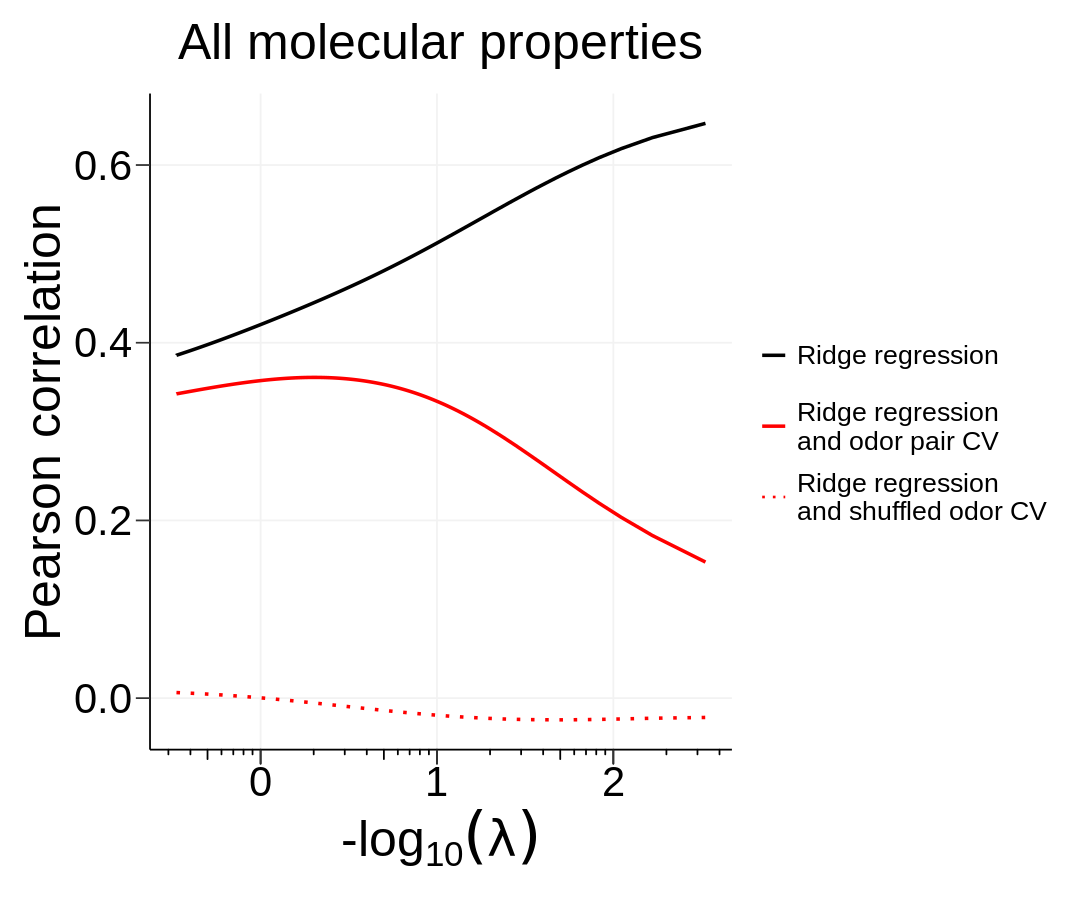

In [104]:
rr_cor_pc_plot <- ggplot(data = rr_stats_gathered, aes(x = -log10(lambda), y = pcorr_cor_value, group = pcorr_cor_id)) +
    geom_line(aes(color = pcorr_cor_id, linetype = pcorr_cor_id),size = 1) +
    ggtitle("All molecular properties") +
    xlab(expression('-'*log[10](lambda))) +
    annotation_logticks(sides = 'b', outside=TRUE) +
    ylab(expression(Pearson~correlation)) +
    scale_linetype_manual(name = "RR",
                          labels = c("full_pcorr_cor"="Ridge regression", "loocv_cor_pcorr"="Ridge regression\nand odor pair CV", "loocv_cor_pcorr_shuffled"="Ridge regression\nand shuffled odor CV"),
                          values=c("solid","solid","dotted")) +
    scale_color_manual(name = "RR",
                       labels = c("full_pcorr_cor"="Ridge regression", "loocv_cor_pcorr"="Ridge regression\nand odor pair CV", "loocv_cor_pcorr_shuffled"="Ridge regression\nand shuffled odor CV"),
                       values = c("black","red","red")) +
    coord_cartesian(clip="off") +
    theme(legend.key=element_blank(),
          legend.key.height=unit(1.5,"cm"),
          legend.title = element_blank(),
          legend.text = element_text(size = 16),
          plot.background = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5, margin=margin(0,0,15,0)),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line = element_line(),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_text(color = "black", size = 30),
          axis.title.y = element_text(color = "black", size = 30),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.5,r=0.5,b=0.5,l=0.5, "cm")) +
    guides(linetype = guide_legend(override.aes = list(size = c(1, 1, 0.75))))

options(repr.plot.width=9, repr.plot.height=7.5)
rr_cor_pc_plot
#ggsave("./plots/fig_3b.pdf", lasso_cor_pc_plot, height = 7.5, width = 9, limitsize = FALSE)


In [105]:
rr_Euc_pc_plot <- ggplot(data = rr_stats_gathered, aes(x = -log10(lambda), y = pcorr_Euc_value, group = pcorr_Euc_id)) +
    geom_line(aes(color = pcorr_Euc_id, linetype = pcorr_Euc_id),size = 1) +
    ggtitle("Response: Euclidean\nAll molecular properties") +
    xlab(expression('-'*log[10](lambda))) +
    annotation_logticks(sides = 'b', outside=TRUE) +
    ylab(expression(Pearson~correlation)) +
    scale_linetype_manual(name = "RR",
                          labels = c("full_pcorr_Euc"="Ridge regression", "loocv_Euc_pcorr"="Ridge regression\nand odor pair CV", "loocv_Euc_pcorr_shuffled"="Ridge regression\nand shuffled odor CV"),
                          values=c("solid","solid","dotted")) +
    scale_color_manual(name = "RR",
                       labels = c("full_pcorr_Euc"="Ridge regression", "loocv_Euc_pcorr"="Ridge regression\nand odor pair CV", "loocv_Euc_pcorr_shuffled"="Ridge regression\nand shuffled odor CV"),
                       values = c("black","red","red")) +
    coord_cartesian(clip="off") +
    theme(legend.key=element_blank(),
          legend.key.height=unit(1.5,"cm"),
          legend.title = element_blank(),
          legend.text = element_text(size = 16),
          plot.background = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5, margin=margin(0,0,15,0)),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line = element_line(),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_text(color = "black", size = 30),
          axis.title.y = element_text(color = "black", size = 30),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.5,r=0.5,b=0.5,l=0.5, "cm")) +
    guides(linetype = guide_legend(override.aes = list(size = c(1, 1, 0.75))))

rr_cor_pc_plot2 <- ggplot(data = rr_stats_gathered, aes(x = -log10(lambda), y = pcorr_cor_value, group = pcorr_cor_id)) +
    geom_line(aes(color = pcorr_cor_id, linetype = pcorr_cor_id),size = 1) +
    ggtitle("Response: correlation\nAll molecular properties") +
    xlab(expression('-'*log[10](lambda))) +
    annotation_logticks(sides = 'b', outside=TRUE) +
    ylab(expression(Pearson~correlation)) +
    scale_linetype_manual(name = "RR",
                          labels = c("full_pcorr_cor"="Ridge regression", "loocv_cor_pcorr"="Ridge regression\nand odor pair CV", "loocv_cor_pcorr_shuffled"="Ridge regression\nand shuffled odor CV"),
                          values=c("solid","solid","dotted")) +
    scale_color_manual(name = "RR",
                       labels = c("full_pcorr_cor"="Ridge regression", "loocv_cor_pcorr"="Ridge regression\nand odor pair CV", "loocv_cor_pcorr_shuffled"="Ridge regression\nand shuffled odor CV"),
                       values = c("black","red","red")) +
    coord_cartesian(clip="off") +
    theme(legend.key=element_blank(),
          legend.key.height=unit(1.5,"cm"),
          legend.title = element_blank(),
          legend.text = element_text(size = 16),
          plot.background = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5, margin=margin(0,0,15,0)),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line = element_line(),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_text(color = "black", size = 30),
          axis.title.y = element_text(color = "black", size = 30),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.5,r=0.5,b=0.5,l=0.5, "cm")) +
    guides(linetype = guide_legend(override.aes = list(size = c(1, 1, 0.75))))

rr_cos_pc_plot <- ggplot(data = rr_stats_gathered, aes(x = -log10(lambda), y = pcorr_cos_value, group = pcorr_cos_id)) +
    geom_line(aes(color = pcorr_cos_id, linetype = pcorr_cos_id),size = 1) +
    ggtitle("Response: cosine\nAll molecular properties") +
    xlab(expression('-'*log[10](lambda))) +
    annotation_logticks(sides = 'b', outside=TRUE) +
    ylab(expression(Pearson~correlation)) +
    scale_linetype_manual(name = "RR",
                          labels = c("full_pcorr_cos"="Ridge regression", "loocv_cos_pcorr"="Ridge regression\nand odor pair CV", "loocv_cos_pcorr_shuffled"="Ridge regression\nand shuffled odor CV"),
                          values=c("solid","solid","dotted")) +
    scale_color_manual(name = "RR",
                       labels = c("full_pcorr_cos"="Ridge regression", "loocv_cos_pcorr"="Ridge regression\nand odor pair CV", "loocv_cos_pcorr_shuffled"="Ridge regression\nand shuffled odor CV"),
                       values = c("black","red","red")) +
    coord_cartesian(clip="off") +
    theme(legend.key=element_blank(),
          legend.key.height=unit(1.5,"cm"),
          legend.title = element_blank(),
          legend.text = element_text(size = 16),
          plot.background = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5, margin=margin(0,0,15,0)),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line = element_line(),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_text(color = "black", size = 30),
          axis.title.y = element_text(color = "black", size = 30),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.5,r=0.5,b=0.5,l=0.5, "cm")) +
    guides(linetype = guide_legend(override.aes = list(size = c(1, 1, 0.75))))

rr_Euc_mse_plot <- ggplot(data = rr_stats_gathered, aes(x = -log10(lambda), y = mse_Euc_value, group = mse_Euc_id)) +
    geom_line(aes(color = mse_Euc_id, linetype = mse_Euc_id),size = 1) +
    ggtitle("Response: Euclidean\nAll molecular properties") +
    xlab(expression('-'*log[10](lambda))) +
    annotation_logticks(sides = 'b', outside=TRUE) +
    ylab(expression(Mean~squared~error)) +
    scale_linetype_manual(name = "RR",
                          labels = c("full_mse_Euc"="Ridge regression", "loocv_Euc_avg_mse"="Ridge regression\nand odor pair CV", "loocv_Euc_avg_mse_shuffled"="Ridge regression\nand shuffled odor CV"),
                          values=c("solid","solid","dotted")) +
    scale_color_manual(name = "RR",
                       labels = c("full_mse_Euc"="Ridge regression", "loocv_Euc_avg_mse"="Ridge regression\nand odor pair CV", "loocv_Euc_avg_mse_shuffled"="Ridge regression\nand shuffled odor CV"),
                       values = c("black","red","red")) +
    coord_cartesian(clip="off") +
    theme(legend.key=element_blank(),
          legend.key.height=unit(1.5,"cm"),
          legend.title = element_blank(),
          legend.text = element_text(size = 16),
          plot.background = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5, margin=margin(0,0,15,0)),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line = element_line(),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_text(color = "black", size = 30),
          axis.title.y = element_text(color = "black", size = 30),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.5,r=0.5,b=0.5,l=0.5, "cm")) +
    guides(linetype = guide_legend(override.aes = list(size = c(1, 1, 0.75))))

rr_cor_mse_plot <- ggplot(data = rr_stats_gathered, aes(x = -log10(lambda), y = mse_cor_value, group = mse_cor_id)) +
    geom_line(aes(color = mse_cor_id, linetype = mse_cor_id),size = 1) +
    ggtitle("Response: correlation\nAll molecular properties") +
    xlab(expression('-'*log[10](lambda))) +
    annotation_logticks(sides = 'b', outside=TRUE) +
    ylab(expression(Mean~squared~error)) +
    scale_linetype_manual(name = "RR",
                          labels = c("full_mse_cor"="Ridge regression", "loocv_cor_avg_mse"="Ridge regression\nand odor pair CV", "loocv_cor_avg_mse_shuffled"="Ridge regression\nand shuffled odor CV"),
                          values=c("solid","solid","dotted")) +
    scale_color_manual(name = "RR",
                       labels = c("full_mse_cor"="Ridge regression", "loocv_cor_avg_mse"="Ridge regression\nand odor pair CV", "loocv_cor_avg_mse_shuffled"="Ridge regression\nand shuffled odor CV"),
                       values = c("black","red","red")) +
    coord_cartesian(clip="off") +
    theme(legend.key=element_blank(),
          legend.key.height=unit(1.5,"cm"),
          legend.title = element_blank(),
          legend.text = element_text(size = 16),
          plot.background = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5, margin=margin(0,0,15,0)),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line = element_line(),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_text(color = "black", size = 30),
          axis.title.y = element_text(color = "black", size = 30),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.5,r=0.5,b=0.5,l=0.5, "cm")) +
    guides(linetype = guide_legend(override.aes = list(size = c(1, 1, 0.75))))

rr_cos_mse_plot <- ggplot(data = rr_stats_gathered, aes(x = -log10(lambda), y = mse_cos_value, group = mse_cos_id)) +
    geom_line(aes(color = mse_cos_id, linetype = mse_cos_id),size = 1) +
    ggtitle("Response: cosine\nAll molecular properties") +
    xlab(expression('-'*log[10](lambda))) +
    annotation_logticks(sides = 'b', outside=TRUE) +
    ylab(expression(Mean~squared~error)) +
    scale_linetype_manual(name = "RR",
                          labels = c("full_mse_cos"="Ridge regression", "loocv_cos_avg_mse"="Ridge regression\nand odor pair CV", "loocv_cos_avg_mse_shuffled"="Ridge regression\nand shuffled odor CV"),
                          values=c("solid","solid","dotted")) +
    scale_color_manual(name = "RR",
                       labels = c("full_mse_cos"="Ridge regression", "loocv_cos_avg_mse"="Ridge regression\nand odor pair CV", "loocv_cos_avg_mse_shuffled"="Ridge regression\nand shuffled odor CV"),
                       values = c("black","red","red")) +
    coord_cartesian(clip="off") +
    theme(legend.key=element_blank(),
          legend.key.height=unit(1.5,"cm"),
          legend.title = element_blank(),
          legend.text = element_text(size = 16),
          plot.background = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5, margin=margin(0,0,15,0)),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line = element_line(),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_text(color = "black", size = 30),
          axis.title.y = element_text(color = "black", size = 30),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.5,r=0.5,b=0.5,l=0.5, "cm")) +
    guides(linetype = guide_legend(override.aes = list(size = c(1, 1, 0.75))))


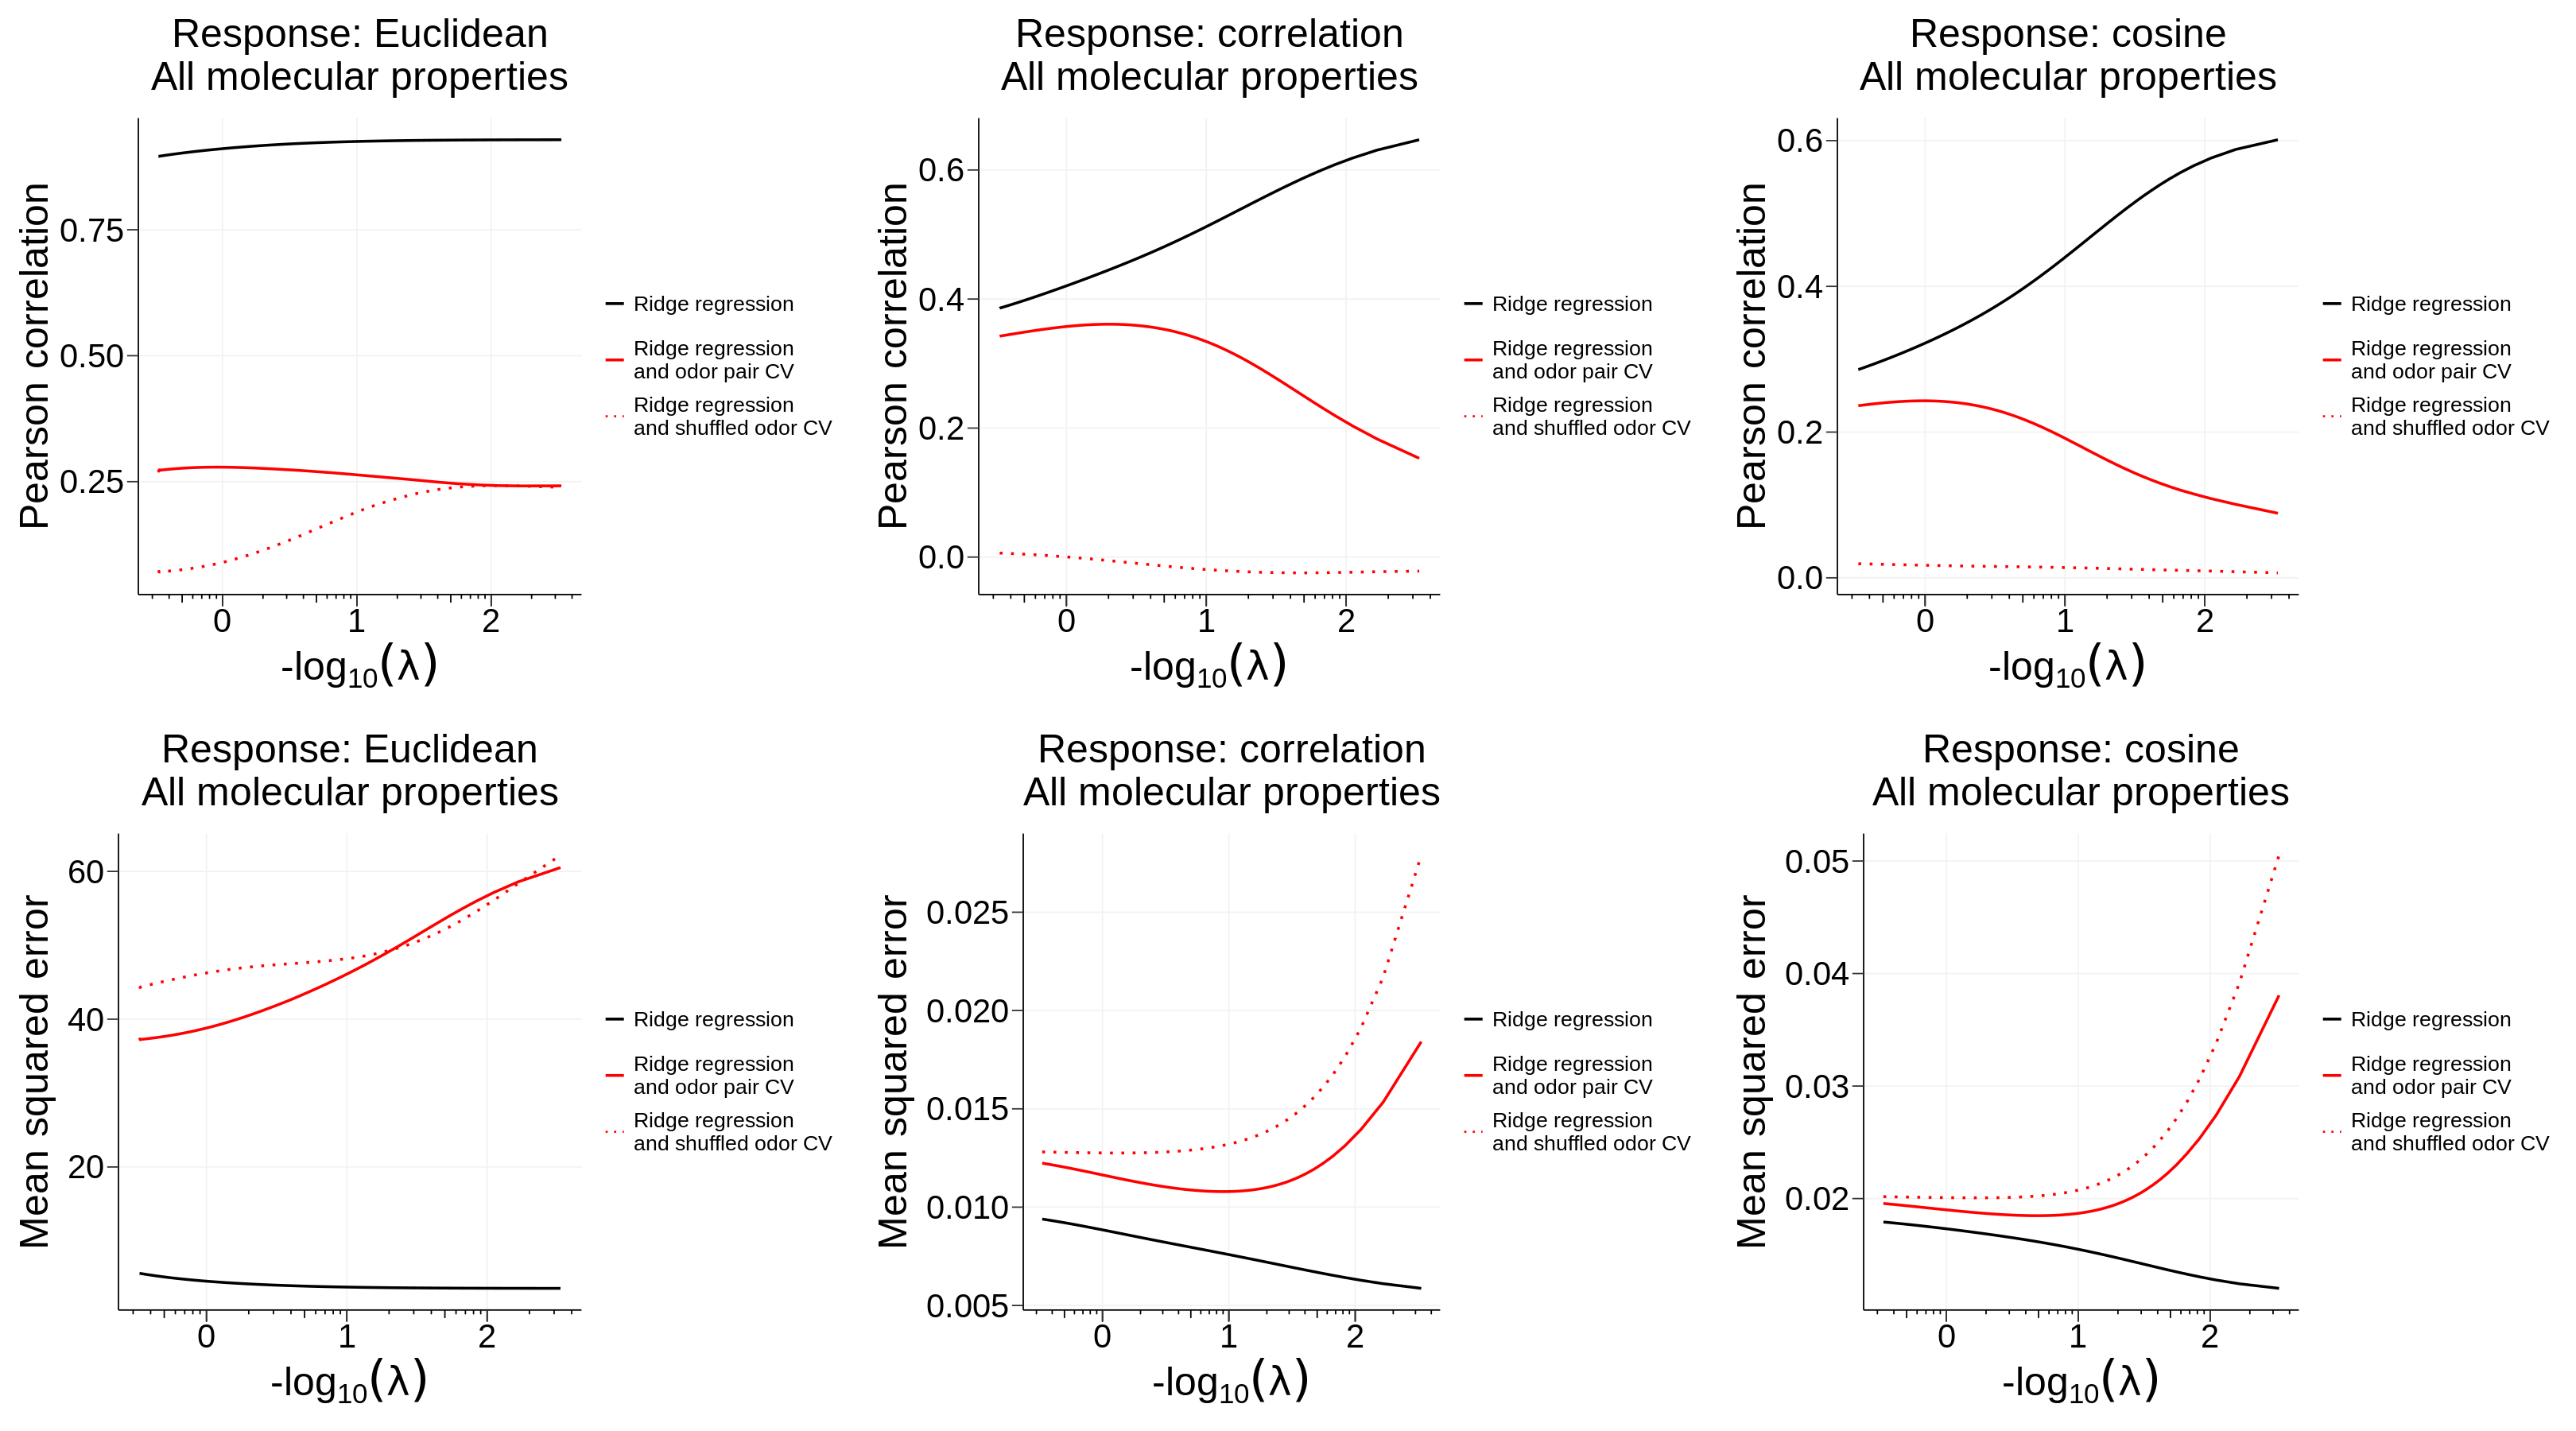

In [103]:
options(repr.plot.width=27, repr.plot.height=15)
rr_plot_compiled <- ggarrange(rr_Euc_pc_plot, rr_cor_pc_plot2, rr_cos_pc_plot,
                              rr_Euc_mse_plot, rr_cor_mse_plot, rr_cos_mse_plot,
                              ncol=3, nrow=2)
rr_plot_compiled
#ggsave("./plots/fig_3_supp2b.pdf", rr_plot_compiled, height = 22.5, width = 27, limitsize = FALSE)

# XGBoost - stats & plotting

In [55]:
#Load full fit data
xgboost_optDesc_fullFit <- read.delim("./ohe_features/xgb_fullFit_optDesc_variousMetrics.csv", header=T, sep=',')
xgboost_optDesc_fullFit <- xgboost_optDesc_fullFit[,-1]
#Load LOOCV data
xgboost_optDesc_loocv <- read.delim("./ohe_features/xgb_LOOCV_optDesc_variousMetrics.csv", header=T, sep=',')
xgboost_optDesc_loocv <- xgboost_optDesc_loocv[,-1]

In [57]:
#Calculate Pearson correlation values for XGBoost models fit with opt descriptors
xgb_fullFit_optDesc_Euc_r <- cor(xgboost_optDesc_fullFit$fullFit_ytrue_Euc, xgboost_optDesc_fullFit$fullFit_ypred_Euc)
xgb_fullFit_optDesc_cor_r <- cor(xgboost_optDesc_fullFit$fullFit_ytrue_cor, xgboost_optDesc_fullFit$fullFit_ypred_cor)
xgb_fullFit_optDesc_cos_r <- cor(xgboost_optDesc_fullFit$fullFit_ytrue_cos, xgboost_optDesc_fullFit$fullFit_ypred_cos)
xgb_loocv_optDesc_Euc_r <- cor(xgboost_optDesc_loocv$ytrue_Euc, xgboost_optDesc_loocv$ypred_Euc)
xgb_loocv_optDesc_cor_r <- cor(xgboost_optDesc_loocv$ytrue_cor, xgboost_optDesc_loocv$ypred_cor)
xgb_loocv_optDesc_cos_r <- cor(xgboost_optDesc_loocv$ytrue_cos, xgboost_optDesc_loocv$ypred_cos)
xgb_loocv_optDesc_shuffled_Euc_r <- cor(xgboost_optDesc_loocv$ytrue_Euc, xgboost_optDesc_loocv$ypred_Euc_shuffled)
xgb_loocv_optDesc_shuffled_cor_r <- cor(xgboost_optDesc_loocv$ytrue_cor, xgboost_optDesc_loocv$ypred_cor_shuffled)
xgb_loocv_optDesc_shuffled_cos_r <- cor(xgboost_optDesc_loocv$ytrue_cos, xgboost_optDesc_loocv$ypred_cos_shuffled)

In [56]:
#Calculate all desc Euc mse
xgb_optDesc_Euc_mse <- cbind.data.frame(xgb_mse_fullFit_Euc = mean((xgboost_optDesc_fullFit$fullFit_ytrue_Euc - xgboost_optDesc_fullFit$fullFit_ypred_Euc)^2),
                                        xgb_mse_loocv_Euc = mean((xgboost_optDesc_loocv$ytrue_Euc - xgboost_optDesc_loocv$ypred_Euc)^2),
                                        xgb_mse_loocv_shuffled_Euc = mean((xgboost_optDesc_loocv$ytrue_Euc - xgboost_optDesc_loocv$ypred_Euc_shuffled)^2))
#Calculate all desc cor mse
xgb_optDesc_cor_mse <- cbind.data.frame(xgb_mse_fullFit_cor = mean((xgboost_optDesc_fullFit$fullFit_ytrue_cor - xgboost_optDesc_fullFit$fullFit_ypred_cor)^2),
                                        xgb_mse_loocv_cor = mean((xgboost_optDesc_loocv$ytrue_cor - xgboost_optDesc_loocv$ypred_cor)^2),
                                        xgb_mse_loocv_shuffled_cor = mean((xgboost_optDesc_loocv$ytrue_cor - xgboost_optDesc_loocv$ypred_cor_shuffled)^2))
#Calculate all desc cos mse
xgb_optDesc_cos_mse <- cbind.data.frame(xgb_mse_fullFit_cos = mean((xgboost_optDesc_fullFit$fullFit_ytrue_cos - xgboost_optDesc_fullFit$fullFit_ypred_cos)^2),
                                        xgb_mse_loocv_cos = mean((xgboost_optDesc_loocv$ytrue_cos - xgboost_optDesc_loocv$ypred_cos)^2),
                                        xgb_mse_loocv_shuffled_cos = mean((xgboost_optDesc_loocv$ytrue_cos - xgboost_optDesc_loocv$ypred_cos_shuffled)^2))
#Gather data
xgb_optDesc_Euc_mse <- xgb_optDesc_Euc_mse %>%
    gather(key='mse_id', value='mse_value')
xgb_optDesc_cor_mse <- xgb_optDesc_cor_mse %>%
    gather(key='mse_id', value='mse_value')
xgb_optDesc_cos_mse <- xgb_optDesc_cos_mse %>%
    gather(key='mse_id', value='mse_value')



`geom_smooth()` using formula 'y ~ x'



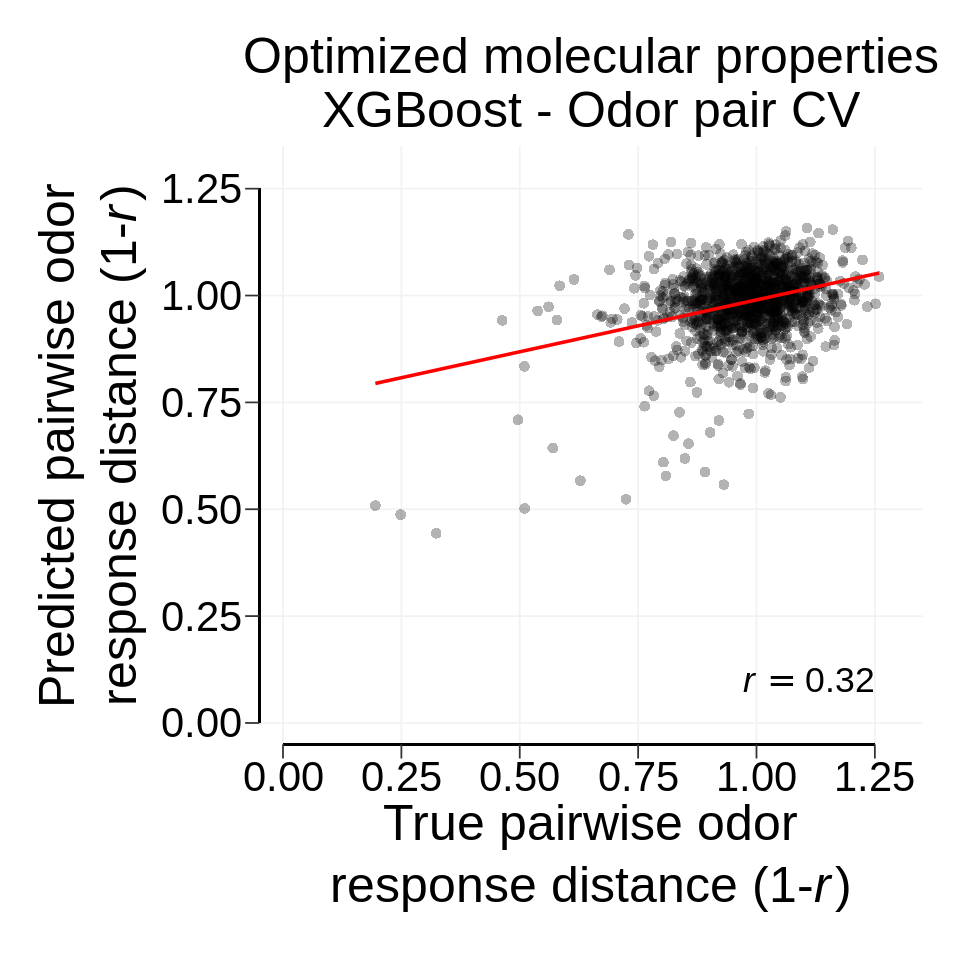

In [58]:
xgboost_optDesc_loocv_cor_plot <- ggplot(data = xgboost_optDesc_loocv, aes(x = ytrue_cor, y = ypred_cor))+
    geom_point(size = 3, alpha = 0.3, stroke = 0) +
    ggtitle("Optimized molecular properties\nXGBoost - Odor pair CV") +
    xlab(bquote(atop("True pairwise odor",
                     paste("response distance (1-",italic(r),")")))) +
    ylab(bquote(atop("Predicted pairwise odor",
                     paste("response distance (1-",italic(r),")")))) +
    coord_cartesian(clip="off") +
    scale_x_continuous(breaks = seq(0,1.25,0.25), limits = c(-0.05,1.35), expand = c(0,0)) +
    scale_y_continuous(breaks = seq(0,1.25,0.25), limits = c(-0.05,1.35), expand = c(0,0)) +
    geom_segment(aes(x = 0, xend = 1.25, y = -0.05, yend = -0.05)) +
    geom_segment(aes(x = -0.05, xend = -0.05, y = 0, yend = 1.25)) +
    theme(plot.background = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line.x = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5),
          axis.line.y = element_blank(),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_text(color = "black", size = 30),
          axis.title.y = element_text(color = "black", size = 30),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.8,r=0.8,b=0.8,l=0.8, "cm")) +
    geom_smooth(method=lm, color = "red", se=F) +
    annotate("text", x = 1.25, y = 0.1, label = paste("italic(r) ==", round(xgb_loocv_optDesc_cor_r, 2)), parse=T, size = 7.5, hjust = 1)


options(repr.plot.width=8, repr.plot.height=8)
xgboost_optDesc_loocv_cor_plot
#ggsave("./plots/fig_3f.pdf", xgboost_optDesc_loocv_cor_plot, height = 8, width = 8)

In [59]:
xgboost_optDesc_fullFit_euc_plot <- ggplot(data = xgboost_optDesc_fullFit, aes(x = fullFit_ytrue_Euc, y = fullFit_ypred_Euc))+
    geom_point(size = 3, alpha = 0.3, stroke = 0) +
    ggtitle("Response: Euclidean\nXGBoost - Train") +
    xlab(bquote(atop("True pairwise odor",
                     paste("response distance")))) +
    ylab(bquote(atop("Predicted pairwise odor",
                     paste("response distance")))) +
    coord_cartesian(clip="off") +
    scale_x_continuous(breaks = seq(10,60,10), limits = c(8,62), expand = c(0,0)) +
    scale_y_continuous(breaks = seq(10,60,10), limits = c(8,62), expand = c(0,0)) +
    geom_segment(aes(x = 10, xend = 60, y = 8, yend = 8)) +
    geom_segment(aes(x = 8, xend = 8, y = 10, yend = 60)) +
    theme(plot.background = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line.x = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5),
          axis.line.y = element_blank(),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_text(color = "black", size = 30),
          axis.title.y = element_text(color = "black", size = 30),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.8,r=0.8,b=0.8,l=0.8, "cm")) +
    geom_smooth(method=lm, color = "red", se=F) +
    annotate("text", x = 50, y = 55, label = paste("italic(r) ==", round(xgb_fullFit_optDesc_Euc_r, 2)), parse=T, size = 7.5)

xgboost_optDesc_loocv_euc_plot2 <- ggplot(data = xgboost_optDesc_loocv, aes(x = ytrue_Euc, y = ypred_Euc))+
    geom_point(size = 3, alpha = 0.3, stroke = 0) +
    ggtitle("Response: Euclidean\nXGBoost - Odor pair CV") +
    xlab(bquote(atop("True pairwise odor",
                     paste("response distance")))) +
    ylab(bquote(atop("Predicted pairwise odor",
                     paste("response distance")))) +
    coord_cartesian(clip="off") +
    scale_x_continuous(breaks = seq(10,60,10), limits = c(9,61), expand = c(0,0)) +
    scale_y_continuous(breaks = seq(10,40,10), limits = c(9,41), expand = c(0,0)) +
    geom_segment(aes(x = 10, xend = 60, y = 9, yend = 9)) +
    geom_segment(aes(x = 9, xend = 9, y = 10, yend = 40)) +
    theme(plot.background = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line.x = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5),
          axis.line.y = element_blank(),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_text(color = "black", size = 30),
          axis.title.y = element_text(color = "black", size = 30),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.8,r=0.8,b=0.8,l=0.8, "cm")) +
    geom_smooth(method=lm, color = "red", se=F) +
    annotate("text", x = 50, y = 38, label = paste("italic(r) ==", round(xgb_loocv_optDesc_Euc_r, 2)), parse=T, size = 7.5)

xgboost_optDesc_loocv_shuffled_euc_plot <- ggplot(data = xgboost_optDesc_loocv, aes(x = ytrue_Euc, y = ypred_Euc_shuffled))+
    geom_point(size = 3, alpha = 0.3, stroke = 0) +
    ggtitle("Response: Euclidean\nXGBoost - Shuffled CV") +
    xlab(bquote(atop("True pairwise odor",
                     paste("response distance")))) +
    ylab(bquote(atop("Predicted pairwise odor",
                     paste("response distance")))) +
    coord_cartesian(clip="off") +
    scale_x_continuous(breaks = seq(10,60,10), limits = c(9,61), expand = c(0,0)) +
    scale_y_continuous(breaks = seq(10,50,10), limits = c(9,51), expand = c(0,0)) +
    geom_segment(aes(x = 10, xend = 60, y = 9, yend = 9)) +
    geom_segment(aes(x = 9, xend = 9, y = 10, yend = 50)) +
    theme(plot.background = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line.x = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5),
          axis.line.y = element_blank(),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_text(color = "black", size = 30),
          axis.title.y = element_text(color = "black", size = 30),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.8,r=0.8,b=0.8,l=0.8, "cm")) +
    geom_smooth(method=lm, color = "red", se=F) +
    annotate("text", x = 50, y = 48, label = paste("italic(r) ==", round(xgb_loocv_optDesc_shuffled_Euc_r, 2)), parse=T, size = 7.5)

xgboost_optDesc_fullFit_cor_plot <- ggplot(data = xgboost_optDesc_fullFit, aes(x = fullFit_ytrue_cor, y = fullFit_ypred_cor))+
    geom_point(size = 3, alpha = 0.3, stroke = 0) +
    ggtitle("Response: correlation\nXGBoost - Train") +
    xlab(bquote(atop("True pairwise odor",
                     paste("response distance")))) +
    ylab(bquote(atop("Predicted pairwise odor",
                     paste("response distance")))) +
    coord_cartesian(clip="off") +
    scale_x_continuous(breaks = seq(0,2,0.5), limits = c(-0.1,2.1), expand = c(0,0)) +
    scale_y_continuous(breaks = seq(0,2,0.5), limits = c(-0.1,2.1), expand = c(0,0)) +
    geom_segment(aes(x = 0, xend = 2, y = -0.1, yend = -0.1)) +
    geom_segment(aes(x = -0.1, xend = -0.1, y = 0, yend = 2)) +
    theme(plot.background = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line.x = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5),
          axis.line.y = element_blank(),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_text(color = "black", size = 30),
          axis.title.y = element_text(color = "black", size = 30),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.8,r=0.8,b=0.8,l=0.8, "cm")) +
    geom_smooth(method=lm, color = "red", se=F) +
    annotate("text", x = 1.75, y = 1.85, label = paste("italic(r) ==", round(xgb_fullFit_optDesc_cor_r, 2)), parse=T, size = 7.5)

xgboost_optDesc_loocv_cor_plot <- ggplot(data = xgboost_optDesc_loocv, aes(x = ytrue_cor, y = ypred_cor))+
    geom_point(size = 3, alpha = 0.3, stroke = 0) +
    ggtitle("Response: correlation\nXGBoost - Odor pair CV") +
    xlab(bquote(atop("True pairwise odor",
                     paste("response distance")))) +
    ylab(bquote(atop("Predicted pairwise odor",
                     paste("response distance")))) +
    coord_cartesian(clip="off") +
    scale_x_continuous(breaks = seq(0,2,0.5), limits = c(-0.1,2.1), expand = c(0,0)) +
    scale_y_continuous(breaks = seq(0,2,0.5), limits = c(-0.1,2.1), expand = c(0,0)) +
    geom_segment(aes(x = 0, xend = 2, y = -0.1, yend = -0.1)) +
    geom_segment(aes(x = -0.1, xend = -0.1, y = 0, yend = 2)) +
    theme(plot.background = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line.x = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5),
          axis.line.y = element_blank(),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_text(color = "black", size = 30),
          axis.title.y = element_text(color = "black", size = 30),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.8,r=0.8,b=0.8,l=0.8, "cm")) +
    geom_smooth(method=lm, color = "red", se=F) +
    annotate("text", x = 1.75, y = 1.85, label = paste("italic(r) ==", round(xgb_loocv_optDesc_cor_r, 2)), parse=T, size = 7.5)

xgboost_optDesc_loocv_shuffled_cor_plot <- ggplot(data = xgboost_optDesc_loocv, aes(x = ytrue_cor, y = ypred_cor_shuffled))+
    geom_point(size = 3, alpha = 0.3, stroke = 0) +
    ggtitle("Response: correlation\nXGBoost - Shuffled CV") +
    xlab(bquote(atop("True pairwise odor",
                     paste("response distance")))) +
    ylab(bquote(atop("Predicted pairwise odor",
                     paste("response distance")))) +
    coord_cartesian(clip="off") +
    scale_x_continuous(breaks = seq(0,2,0.5), limits = c(-0.1,2.1), expand = c(0,0)) +
    scale_y_continuous(breaks = seq(0,2,0.5), limits = c(-0.1,2.1), expand = c(0,0)) +
    geom_segment(aes(x = 0, xend = 2, y = -0.1, yend = -0.1)) +
    geom_segment(aes(x = -0.1, xend = -0.1, y = 0, yend = 2)) +
    theme(plot.background = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line.x = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5),
          axis.line.y = element_blank(),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_text(color = "black", size = 30),
          axis.title.y = element_text(color = "black", size = 30),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.8,r=0.8,b=0.8,l=0.8, "cm")) +
    geom_smooth(method=lm, color = "red", se=F) +
    annotate("text", x = 1.75, y = 1.85, label = paste("italic(r) ==", round(xgb_loocv_optDesc_shuffled_cor_r, 2)), parse=T, size = 7.5)


xgboost_optDesc_fullFit_cos_plot <- ggplot(data = xgboost_optDesc_fullFit, aes(x = fullFit_ytrue_cos, y = fullFit_ypred_cos))+
    geom_point(size = 3, alpha = 0.3, stroke = 0) +
    ggtitle("Response: cosine\nXGBoost - Train") +
    xlab(bquote(atop("True pairwise odor",
                     paste("response distance")))) +
    ylab(bquote(atop("Predicted pairwise odor",
                     paste("response distance")))) +
    coord_cartesian(clip="off") +
    scale_x_continuous(breaks = seq(0,2,0.5), limits = c(-0.1,2.1), expand = c(0,0)) +
    scale_y_continuous(breaks = seq(0,2,0.5), limits = c(-0.1,2.1), expand = c(0,0)) +
    geom_segment(aes(x = 0, xend = 2, y = -0.1, yend = -0.1)) +
    geom_segment(aes(x = -0.1, xend = -0.1, y = 0, yend = 2)) +
    theme(plot.background = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line.x = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5),
          axis.line.y = element_blank(),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_text(color = "black", size = 30),
          axis.title.y = element_text(color = "black", size = 30),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.8,r=0.8,b=0.8,l=0.8, "cm")) +
    geom_smooth(method=lm, color = "red", se=F) +
    annotate("text", x = 1.75, y = 1.85, label = paste("italic(r) ==", round(xgb_fullFit_optDesc_cos_r, 2)), parse=T, size = 7.5)

xgboost_optDesc_loocv_cos_plot <- ggplot(data = xgboost_optDesc_loocv, aes(x = ytrue_cos, y = ypred_cos))+
    geom_point(size = 3, alpha = 0.3, stroke = 0) +
    ggtitle("Response: cosine\nXGBoost - Odor pair CV") +
    xlab(bquote(atop("True pairwise odor",
                     paste("response distance")))) +
    ylab(bquote(atop("Predicted pairwise odor",
                     paste("response distance")))) +
    coord_cartesian(clip="off") +
    scale_x_continuous(breaks = seq(0,2,0.5), limits = c(-0.1,2.1), expand = c(0,0)) +
    scale_y_continuous(breaks = seq(0,2,0.5), limits = c(-0.1,2.1), expand = c(0,0)) +
    geom_segment(aes(x = 0, xend = 2, y = -0.1, yend = -0.1)) +
    geom_segment(aes(x = -0.1, xend = -0.1, y = 0, yend = 2)) +
    theme(plot.background = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line.x = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5),
          axis.line.y = element_blank(),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_text(color = "black", size = 30),
          axis.title.y = element_text(color = "black", size = 30),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.8,r=0.8,b=0.8,l=0.8, "cm")) +
    geom_smooth(method=lm, color = "red", se=F) +
    annotate("text", x = 1.75, y = 1.85, label = paste("italic(r) ==", round(xgb_loocv_optDesc_cos_r, 2)), parse=T, size = 7.5)

xgboost_optDesc_loocv_shuffled_cos_plot <- ggplot(data = xgboost_optDesc_loocv, aes(x = ytrue_cos, y = ypred_cos_shuffled))+
    geom_point(size = 3, alpha = 0.3, stroke = 0) +
    ggtitle("Response: cosine\nXGBoost - Shuffled CV") +
    xlab(bquote(atop("True pairwise odor",
                     paste("response distance")))) +
    ylab(bquote(atop("Predicted pairwise odor",
                     paste("response distance")))) +
    coord_cartesian(clip="off") +
    scale_x_continuous(breaks = seq(0,2,0.5), limits = c(-0.1,2.1), expand = c(0,0)) +
    scale_y_continuous(breaks = seq(0,2,0.5), limits = c(-0.1,2.1), expand = c(0,0)) +
    geom_segment(aes(x = 0, xend = 2, y = -0.1, yend = -0.1)) +
    geom_segment(aes(x = -0.1, xend = -0.1, y = 0, yend = 2)) +
    theme(plot.background = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line.x = element_blank(),
          plot.title = element_text(size = 30, hjust = 0.5),
          axis.line.y = element_blank(),
          axis.text.x = element_text(color = "black", size = 25),
          axis.text.y = element_text(color = "black", size = 25),
          axis.title.x = element_text(color = "black", size = 30),
          axis.title.y = element_text(color = "black", size = 30),
          axis.ticks.length.x = unit(0.3, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.8,r=0.8,b=0.8,l=0.8, "cm")) +
    geom_smooth(method=lm, color = "red", se=F) +
    annotate("text", x = 1.75, y = 1.85, label = paste("italic(r) ==", round(xgb_loocv_optDesc_shuffled_cos_r, 2)), parse=T, size = 7.5)



In [60]:
xgb_optDesc_Euc_mse_plot <- ggplot(data = xgb_optDesc_Euc_mse, aes(x = mse_id, y = mse_value, fill = mse_id)) +
    geom_col(width = 0.7) +
    ggtitle("XGBoost response: Euclidean") +
    ylab(expression(Mean~squared~error)) +
    scale_x_discrete(label = c("Train",
                               "CV",
                               "Shuffled CV")) +
    scale_y_continuous(breaks = seq(0,50,10), limits = c(0,50)) +
    theme(legend.position = "none",
          plot.background = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line.x = element_line(),
          plot.title = element_text(size = 30, hjust = 0.5),
          axis.line.y = element_line(),
          axis.text.x = element_text(color = "black", size = 20, hjust = 0.5,margin = margin(t = 10)),
          axis.text.y = element_text(color = "black", size = 20),
          axis.title.x = element_blank(),
          axis.title.y = element_text(color = "black", size = 30),
          axis.ticks.length.x = unit(0, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.5,r=0.5,b=0.5,l=0.5, "cm")) +
    annotate("text", x = 1, y = 3, label = round(xgb_optDesc_Euc_mse$mse_value[1],2), size = 7.5) +
    annotate("text", x = 2, y = 30, label = round(xgb_optDesc_Euc_mse$mse_value[2],2), size = 7.5) +
    annotate("text", x = 3, y = 45, label = round(xgb_optDesc_Euc_mse$mse_value[3],2), size = 7.5)

xgb_optDesc_cor_mse_plot <- ggplot(data = xgb_optDesc_cor_mse, aes(x = mse_id, y = mse_value, fill = mse_id)) +
    geom_col(width = 0.7) +
    ggtitle("XGBoost response: correlation") +
    ylab(expression(Mean~squared~error)) +
    scale_x_discrete(label = c("Train",
                               "CV",
                               "Shuffled CV")) +
    scale_y_continuous(breaks = seq(0,0.02,0.004), limits = c(0,0.02)) +
    theme(legend.position = "none",
          plot.background = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line.x = element_line(),
          plot.title = element_text(size = 30, hjust = 0.5),
          axis.line.y = element_line(),
          axis.text.x = element_text(color = "black", size = 20, hjust = 0.5,margin = margin(t = 10)),
          axis.text.y = element_text(color = "black", size = 20),
          axis.title.x = element_blank(),
          axis.title.y = element_text(color = "black", size = 30),
          axis.ticks.length.x = unit(0, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.5,r=0.5,b=0.5,l=0.5, "cm")) +
    annotate("text", x = 1, y = 0.0015, label = signif(xgb_optDesc_cor_mse$mse_value[1], digits = 2), size = 7.5) +
    annotate("text", x = 2, y = 0.012, label = round(xgb_optDesc_cor_mse$mse_value[2], digits = 2), size = 7.5) +
    annotate("text", x = 3, y = 0.018, label = round(xgb_optDesc_cor_mse$mse_value[3], digits = 2), size = 7.5)

xgb_optDesc_cos_mse_plot <- ggplot(data = xgb_optDesc_cos_mse, aes(x = mse_id, y = mse_value, fill = mse_id)) +
    geom_col(width = 0.7) +
    ggtitle("XGBoost response: cosine") +
    ylab(expression(Mean~squared~error)) +
    scale_x_discrete(label = c("Train",
                               "CV",
                               "Shuffled CV")) +
    scale_y_continuous(breaks = seq(0,0.035,0.007), limits = c(0,0.035)) +
    theme(legend.position = "none",
          plot.background = element_blank(),
          panel.border = element_blank(),
          panel.grid.major = element_line(color="gray95"),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          axis.line.x = element_line(),
          plot.title = element_text(size = 30, hjust = 0.5),
          axis.line.y = element_line(),
          axis.text.x = element_text(color = "black", size = 20, hjust = 0.5,margin = margin(t = 10)),
          axis.text.y = element_text(color = "black", size = 20),
          axis.title.x = element_blank(),
          axis.title.y = element_text(color = "black", size = 30),
          axis.ticks.length.x = unit(0, "cm"),
          axis.ticks.length.y = unit(0.3, "cm"),
          plot.margin = margin(t=0.5,r=0.5,b=0.5,l=0.5, "cm")) +
    annotate("text", x = 1, y = 0.003, label = signif(xgb_optDesc_cos_mse$mse_value[1], digits = 2), size = 7.5) +
    annotate("text", x = 2, y = 0.025, label = round(xgb_optDesc_cos_mse$mse_value[2], digits = 2), size = 7.5) +
    annotate("text", x = 3, y = 0.031, label = round(xgb_optDesc_cos_mse$mse_value[3], digits = 2), size = 7.5)



`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1 rows containing missing values (position_stack).”
`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



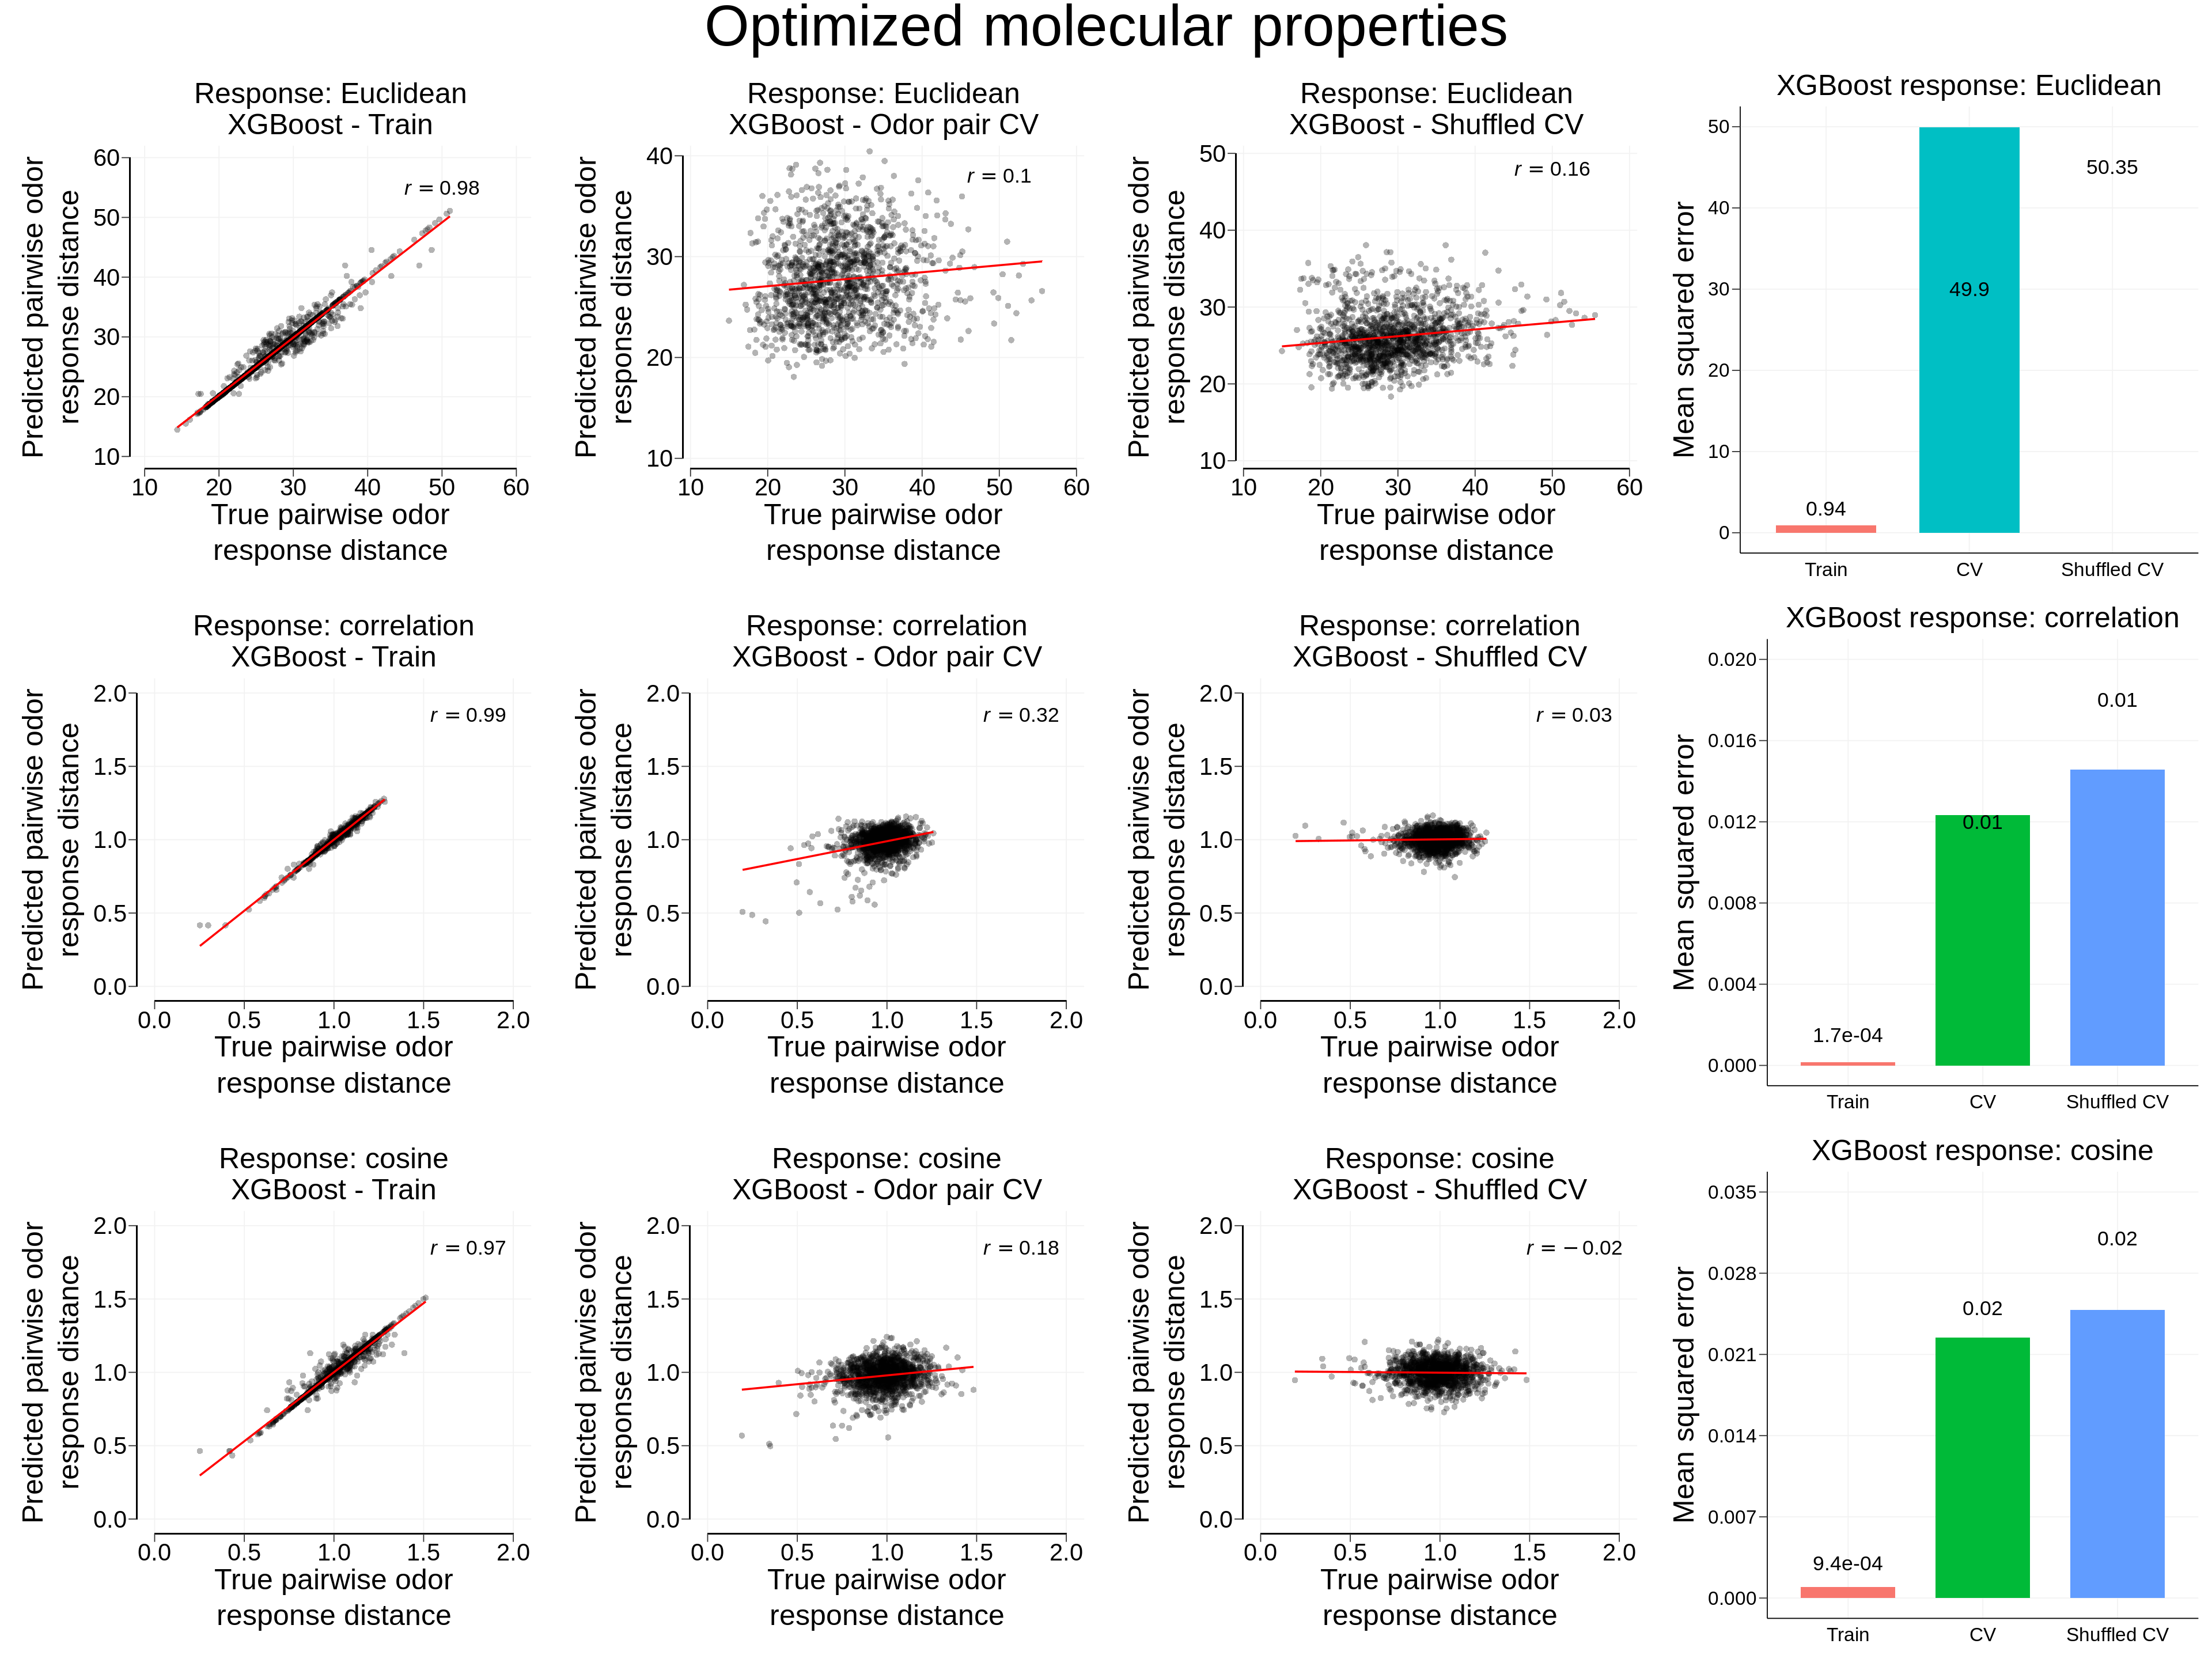

In [61]:
options(repr.plot.width=32, repr.plot.height=24)
xgboost_optDesc_compiled_plot <- ggarrange(xgboost_optDesc_fullFit_euc_plot,
                                           xgboost_optDesc_loocv_euc_plot2,
                                           xgboost_optDesc_loocv_shuffled_euc_plot,
                                           xgb_optDesc_Euc_mse_plot,
                                           xgboost_optDesc_fullFit_cor_plot,
                                           xgboost_optDesc_loocv_cor_plot,
                                           xgboost_optDesc_loocv_shuffled_cor_plot,
                                           xgb_optDesc_cor_mse_plot,
                                           xgboost_optDesc_fullFit_cos_plot,
                                           xgboost_optDesc_loocv_cos_plot,
                                           xgboost_optDesc_loocv_shuffled_cos_plot,
                                           xgb_optDesc_cos_mse_plot,
                                           ncol = 4, nrow = 3)

xgboost_optDesc_compiled_plot <- annotate_figure(xgboost_optDesc_compiled_plot,
                                                 top = text_grob(bquote(Optimized~molecular~properties), size = 60))


xgboost_optDesc_compiled_plot

